In [1]:
import math
import xarray as xr
import cartopy.crs as crs
import matplotlib as mpl
from matplotlib import pyplot as plt 
import matplotlib.pylab as plt
import matplotlib.path as mpath
from matplotlib.pyplot import figure
import numpy as np
import cartopy.feature as cfeature
from matplotlib.cm import get_cmap
import pyproj
import utm
import pandas as pd 
import traceback 
from pathlib import Path  
import os  
import numpy.ma as ma
import netCDF4 as nc
from netCDF4 import Dataset
import glob
import datetime as dt
import metpy.calc as mpcalc
from metpy.units import units
from metpy.cbook import get_test_data
from metpy.io import metar
from metpy.plots.declarative import (BarbPlot, ContourPlot, FilledContourPlot, MapPanel,
                                     PanelContainer, PlotObs)
from netCDF4 import date2num,num2date
import wrf
from wrf import (getvar, interplevel, to_np, latlon_coords, get_cartopy,
                 cartopy_xlim, cartopy_ylim)
from wrf import getvar, interplevel, to_np, get_basemap, latlon_coords
from wrf import getvar, xy, interp2dxy
from wrf import to_np, getvar, CoordPair, vertcross
from matplotlib.cm import get_cmap
from matplotlib.ticker import (NullFormatter, ScalarFormatter)

In [2]:
#CURRENT DATA
cur_wrfout6 = Dataset('CUR_wrfout_d03_2018-03-25_06_00_00')

cur_wrfout10 = Dataset('CUR_wrfout_d03_2018-03-25_10_00_00')
cur_wrfout11= Dataset('CUR_wrfout_d03_2018-03-25_11_00_00')
cur_wrfout12 = Dataset('CUR_wrfout_d03_2018-03-25_12_00_00')
cur_wrfout13= Dataset('CUR_wrfout_d03_2018-03-25_13_00_00')


#SST DATA
sst_wrfout6 = Dataset('SST_wrfout_d03_2018-03-25_06_00_00')

sst_wrfout10 = Dataset('SST_wrfout_d03_2018-03-25_10_00_00')
sst_wrfout11 = Dataset('SST_wrfout_d03_2018-03-25_11_00_00')
sst_wrfout12 = Dataset('SST_wrfout_d03_2018-03-25_12_00_00')
sst_wrfout13 = Dataset('SST_wrfout_d03_2018-03-25_13_00_00')


In [3]:
xlat =getvar(cur_wrfout6, "XLAT")
xlon = getvar(cur_wrfout6, "XLONG")
print(xlon.shape)
#print(cur_wrfout6.variables)
#south box
#26-26.6 N, -89.2- -90.4 W #67, 118
xlon1_south = np.where(xlon[400,:]>=-90.4) 
xlon2_south = np.where(xlon[400,:]<=-89.2)
lon_int_south = np.intersect1d(xlon1_south, xlon2_south)

xlat1_south = np.where(xlat[:,400]>=26.0)
xlat2_south = np.where(xlat[:,400]<=26.6)
lat_int_south = np.intersect1d(xlat1_south, xlat2_south)

#reshape lat lon array
south_lon = [xlon[400][x] for x in lon_int_south] 
south_lat = [xlat[x][400] for x in lat_int_south] 
print('south lon: ', np.array(south_lon).shape)
print('south lat: ', np.array(south_lat).shape)

#north box  #67, 167
#27.9-28.5 N, -89- -90.7 W
xlon1_north = np.where(xlon[400,:]>=-90.7) 
xlon2_north = np.where(xlon[400,:]<=-89.0)
lon_int_north = np.intersect1d(xlon1_north, xlon2_north)

xlat1_north = np.where(xlat[:,400]>=27.9)
xlat2_north = np.where(xlat[:,400]<=28.5)
lat_int_north = np.intersect1d(xlat1_north, xlat2_north)

#reshape lat lon array
north_lon = [xlon[400][x] for x in lon_int_north] 
north_lat = [xlat[x][400] for x in lat_int_north] 
print('north lon: ', np.array(north_lon).shape)
print('north lat: ', np.array(north_lat).shape)

(474, 639)
south lon:  (118,)
south lat:  (67,)
north lon:  (167,)
north lat:  (67,)


In [4]:
#Get PBLH
#Not staggered
cur_pblh_10 = getvar(cur_wrfout10, "PBLH")
cur_pblh_11 = getvar(cur_wrfout11, "PBLH")
cur_pblh_12 = getvar(cur_wrfout12, "PBLH")
cur_pblh_13 = getvar(cur_wrfout13, "PBLH")

sst_pblh_10 = getvar(sst_wrfout10, "PBLH")
sst_pblh_11 = getvar(sst_wrfout11, "PBLH")
sst_pblh_12 = getvar(sst_wrfout12, "PBLH")
sst_pblh_13 = getvar(sst_wrfout13, "PBLH")

#Qv
cur_qv10 = getvar(cur_wrfout10, "QVAPOR")
cur_qv11 = getvar(cur_wrfout11, "QVAPOR")
cur_qv12 = getvar(cur_wrfout12, "QVAPOR")
cur_qv13 = getvar(cur_wrfout13, "QVAPOR")

sst_qv10 = getvar(sst_wrfout10, "QVAPOR")
sst_qv11 = getvar(sst_wrfout11, "QVAPOR")
sst_qv12 = getvar(sst_wrfout12, "QVAPOR")
sst_qv13 = getvar(sst_wrfout13, "QVAPOR")

#GET THETA & TV 
#base pressure
sst_baseP10 = getvar(sst_wrfout10, 'P00')
sst_baseP11 = getvar(sst_wrfout11, 'P00')
sst_baseP12 = getvar(sst_wrfout12, 'P00')
sst_baseP13 = getvar(sst_wrfout13, 'P00')

cur_baseP10 = getvar(cur_wrfout10, 'P00')
cur_baseP11 = getvar(cur_wrfout11, 'P00')
cur_baseP12 = getvar(cur_wrfout12, 'P00')
cur_baseP13 = getvar(cur_wrfout13, 'P00')


#perturbation pressure
sst_pertP10 = getvar(sst_wrfout10, 'P')
sst_pertP11 = getvar(sst_wrfout11, 'P')
sst_pertP12 = getvar(sst_wrfout12, 'P')
sst_pertP13 = getvar(sst_wrfout13, 'P')

cur_pertP10 = getvar(cur_wrfout10, 'P')
cur_pertP11 = getvar(cur_wrfout11, 'P')
cur_pertP12 = getvar(cur_wrfout12, 'P')
cur_pertP13 = getvar(cur_wrfout13, 'P')


#full pressure
sst_fullP10 = sst_pertP10 + sst_baseP10
sst_fullP11 = sst_pertP11 + sst_baseP11
sst_fullP12 = sst_pertP12 + sst_baseP12
sst_fullP13 = sst_pertP13 + sst_baseP13

cur_fullP10 = cur_pertP10 + cur_baseP10
cur_fullP11 = cur_pertP11 + cur_baseP11
cur_fullP12 = cur_pertP12 + cur_baseP12
cur_fullP13 = cur_pertP13 + cur_baseP13

#potential temp. perturbation
sst_pertT10 =getvar(sst_wrfout10, 'T')
sst_pertT11 =getvar(sst_wrfout11, 'T')
sst_pertT12 =getvar(sst_wrfout12, 'T')
sst_pertT13 =getvar(sst_wrfout13, 'T')

cur_pertT10 =getvar(cur_wrfout10, 'T')
cur_pertT11 =getvar(cur_wrfout11, 'T')
cur_pertT12 =getvar(cur_wrfout12, 'T')
cur_pertT13 =getvar(cur_wrfout13, 'T')

#reference temperature 
sst_refT10 =getvar(sst_wrfout10, 'T00')
sst_refT11 =getvar(sst_wrfout11, 'T00')
sst_refT12 =getvar(sst_wrfout12, 'T00')
sst_refT13 =getvar(sst_wrfout13, 'T00')

cur_refT10 =getvar(cur_wrfout10, 'T00')
cur_refT11 =getvar(cur_wrfout11, 'T00')
cur_refT12 =getvar(cur_wrfout12, 'T00')
cur_refT13 =getvar(cur_wrfout13, 'T00')

#THETA
#theta = potentional temp. perturbation + reference temp
sst_theta10 = sst_pertT10 + sst_refT10
sst_theta11 = sst_pertT11 + sst_refT11
sst_theta12 = sst_pertT12 + sst_refT12
sst_theta13 = sst_pertT13 + sst_refT13

cur_theta10 = cur_pertT10 + cur_refT10
cur_theta11 = cur_pertT11 + cur_refT11
cur_theta12 = cur_pertT12 + cur_refT12
cur_theta13 = cur_pertT13 + cur_refT13

#TEMPERATURE
#wrf.tk(pres, theta, meta=True, units='K')
sst_temp10 = wrf.tk(sst_fullP10, sst_theta10, meta=True, units='K')
sst_temp11 = wrf.tk(sst_fullP11, sst_theta11, meta=True, units='K')
sst_temp12 = wrf.tk(sst_fullP12, sst_theta12, meta=True, units='K')
sst_temp13 = wrf.tk(sst_fullP13, sst_theta13, meta=True, units='K')

cur_temp10 = wrf.tk(cur_fullP10, cur_theta10, meta=True, units='K')
cur_temp11 = wrf.tk(cur_fullP11, cur_theta11, meta=True, units='K')
cur_temp12 = wrf.tk(cur_fullP12, cur_theta12, meta=True, units='K')
cur_temp13 = wrf.tk(cur_fullP13, cur_theta13, meta=True, units='K')

#tkel = temperature in Kelvin
#VIRTUAL TEMPERATURE
#wrf.tvirtual(tkel, qv, meta=True, units='K') ---- tkel = temp6, qv = QVAPO
#wrf.tvirtual(tkel, qv, meta=True, units='K')

sst_tv_10 = wrf.tvirtual(sst_temp10, sst_qv10 , meta=True, units='K')
sst_tv_11 = wrf.tvirtual(sst_temp11, sst_qv11 , meta=True, units='K')
sst_tv_12 = wrf.tvirtual(sst_temp12, sst_qv12 , meta=True, units='K')
sst_tv_13 = wrf.tvirtual(sst_temp13, sst_qv13 , meta=True, units='K')

cur_tv_10 = wrf.tvirtual(cur_temp10, cur_qv10 , meta=True, units='K')
cur_tv_11 = wrf.tvirtual(cur_temp11, cur_qv11 , meta=True, units='K')
cur_tv_12 = wrf.tvirtual(cur_temp12, cur_qv12 , meta=True, units='K')
cur_tv_13 = wrf.tvirtual(cur_temp13, cur_qv13 , meta=True, units='K')

#Get 
cur_U_10 = getvar(cur_wrfout10, "U")
cur_U_11 = getvar(cur_wrfout11, "U")
cur_U_12 = getvar(cur_wrfout12, "U")
cur_U_13 = getvar(cur_wrfout13, "U")
cur_U_10 = wrf.destagger(cur_U_10, stagger_dim = 2)
cur_U_11  = wrf.destagger(cur_U_11, stagger_dim = 2)
cur_U_12 = wrf.destagger(cur_U_12, stagger_dim = 2)
cur_U_13  = wrf.destagger(cur_U_13, stagger_dim = 2)

cur_U10_10 = getvar(cur_wrfout10, "U10")
cur_U10_11 = getvar(cur_wrfout11, "U10")
cur_U10_12 = getvar(cur_wrfout12, "U10")
cur_U10_13 = getvar(cur_wrfout13, "U10")

sst_U_10 = getvar(sst_wrfout10, "U")
sst_U_11 = getvar(sst_wrfout11, "U")
sst_U_12 = getvar(sst_wrfout12, "U")
sst_U_13 = getvar(sst_wrfout13, "U")
sst_U_10 = wrf.destagger(sst_U_10, stagger_dim = 2)
sst_U_11  = wrf.destagger(sst_U_11, stagger_dim = 2)
sst_U_12 = wrf.destagger(sst_U_12, stagger_dim = 2)
sst_U_13  = wrf.destagger(sst_U_13, stagger_dim = 2)

sst_U10_10 = getvar(sst_wrfout10, "U10")
sst_U10_11 = getvar(sst_wrfout11, "U10")
sst_U10_12 = getvar(sst_wrfout12, "U10")
sst_U10_13 = getvar(sst_wrfout13, "U10")

cur_V_10 = getvar(cur_wrfout10, "V")
cur_V_11 = getvar(cur_wrfout11, "V")
cur_V_12 = getvar(cur_wrfout12, "V")
cur_V_13 = getvar(cur_wrfout13, "V")
cur_V_10 = wrf.destagger(cur_V_10, stagger_dim = 1)
cur_V_11  = wrf.destagger(cur_V_11, stagger_dim = 1)
cur_V_12 = wrf.destagger(cur_V_12, stagger_dim = 1)
cur_V_13  = wrf.destagger(cur_V_13, stagger_dim = 1)

cur_V10_10 = getvar(cur_wrfout10, "V10")
cur_V10_11 = getvar(cur_wrfout11, "V10")
cur_V10_12 = getvar(cur_wrfout12, "V10")
cur_V10_13 = getvar(cur_wrfout13, "V10")

sst_V_10 = getvar(sst_wrfout10, "V")
sst_V_11 = getvar(sst_wrfout11, "V")
sst_V_12 = getvar(sst_wrfout12, "V")
sst_V_13 = getvar(sst_wrfout13, "V")
sst_V_10 = wrf.destagger(sst_V_10, stagger_dim = 1)
sst_V_11  = wrf.destagger(sst_V_11, stagger_dim = 1)
sst_V_12 = wrf.destagger(sst_V_12, stagger_dim = 1)
sst_V_13  = wrf.destagger(sst_V_13, stagger_dim = 1)

sst_V10_10 = getvar(sst_wrfout10, "V10")
sst_V10_11 = getvar(sst_wrfout11, "V10")
sst_V10_12 = getvar(sst_wrfout12, "V10")
sst_V10_13 = getvar(sst_wrfout13, "V10")


In [5]:
#AVG SFC VORT
cur_U10_N = np.mean( np.array([cur_U10_11, cur_U10_12, cur_U10_13]), axis=0 )
cur_V10_N = np.mean( np.array([cur_V10_11, cur_V10_12, cur_V10_13]), axis=0 )
sst_U10_N = np.mean( np.array([sst_U10_11, sst_U10_12, sst_U10_13]), axis=0 )
sst_V10_N = np.mean( np.array([sst_V10_11, sst_V10_12, sst_V10_13]), axis=0 )

cur_U10_S = np.mean( np.array([cur_U10_10, cur_U10_11, cur_U10_12]), axis=0 )
cur_V10_S = np.mean( np.array([cur_V10_10, cur_V10_11, cur_V10_12]), axis=0 )
sst_U10_S = np.mean( np.array([sst_U10_10, sst_U10_11, sst_U10_12]), axis=0 )
sst_V10_S = np.mean( np.array([sst_V10_10, sst_V10_11, sst_V10_12]), axis=0 )

#surface winds on subdomains
#CUR S U
south_cur_u10 = []
for y in lat_int_south:
    inner_arr_cur = []
    for x in lon_int_south:
        inner_arr_cur.append(cur_U10_S[y][x])
    south_cur_u10.append(inner_arr_cur)
south_cur_u10 = np.array(south_cur_u10)
print('S', south_cur_u10.shape)

#CUR N U
north_cur_u10 = []
for y in lat_int_north:
    inner_arr_cur = []
    for x in lon_int_north:
        inner_arr_cur.append(cur_U10_N[y][x])
    north_cur_u10.append(inner_arr_cur)
north_cur_u10 = np.array(north_cur_u10)
print('N', north_cur_u10.shape)

#SST S U
south_sst_u10 = []
for y in lat_int_south:
    inner_arr_sst = []
    for x in lon_int_south:
        inner_arr_sst.append(sst_U10_S[y][x])
    south_sst_u10.append(inner_arr_sst)
south_sst_u10 = np.array(south_sst_u10)
print('S', south_sst_u10.shape)

#SST N U 
north_sst_u10 = []
for y in lat_int_north:
    inner_arr_sst = []
    for x in lon_int_north:
        inner_arr_sst.append(sst_U10_N[y][x])
    north_sst_u10.append(inner_arr_sst)
north_sst_u10 = np.array(north_sst_u10)
print('N', north_sst_u10.shape)

#CUR S V
south_cur_v10 = []
for y in lat_int_south:
    inner_arr_cur = []
    for x in lon_int_south:
        inner_arr_cur.append(cur_V10_S[y][x])
    south_cur_v10.append(inner_arr_cur)
south_cur_v10 = np.array(south_cur_v10)
print('S', south_cur_v10.shape)

#CUR N V
north_cur_v10 = []
for y in lat_int_north:
    inner_arr_cur = []
    for x in lon_int_north:
        inner_arr_cur.append(cur_V10_N[y][x])
    north_cur_v10.append(inner_arr_cur)
north_cur_v10 = np.array(north_cur_v10)
print('N', north_cur_v10.shape)

#SST S V
south_sst_v10 = []
for y in lat_int_south:
    inner_arr_sst = []
    for x in lon_int_south:
        inner_arr_sst.append(sst_V10_S[y][x])
    south_sst_v10.append(inner_arr_sst)
south_sst_v10 = np.array(south_sst_v10)
print('S', south_sst_v10.shape)

#SST N V 
north_sst_v10 = []
for y in lat_int_north:
    inner_arr_sst = []
    for x in lon_int_north:
        inner_arr_sst.append(sst_V10_N[y][x])
    north_sst_v10.append(inner_arr_sst)
north_sst_v10 = np.array(north_sst_v10)
print('N', north_sst_v10.shape)

#surface winds vorticity
north_lon = np.array(north_lon)
south_lon = np.array(south_lon)
north_lat = np.array(north_lat)
south_lat = np.array(south_lat)

N_dxdy = mpcalc.lat_lon_grid_deltas(longitude=north_lon, latitude=north_lat, x_dim=- 1, y_dim=- 2, geod=None)
S_dxdy = mpcalc.lat_lon_grid_deltas(longitude=south_lon, latitude=south_lat, x_dim=- 1, y_dim=- 2, geod=None)

sst_curl10_N = mpcalc.vorticity(u=north_sst_u10*units('m/s'), v=north_sst_v10*units('m/s'), dx=N_dxdy[0], dy=N_dxdy[1])
sst_curl10_S = mpcalc.vorticity(u=south_sst_u10*units('m/s'), v=south_sst_v10*units('m/s'), dx=S_dxdy[0], dy=S_dxdy[1])
cur_curl10_N = mpcalc.vorticity(u=north_cur_u10*units('m/s'), v=north_cur_v10*units('m/s'), dx=N_dxdy[0], dy=N_dxdy[1])
cur_curl10_S = mpcalc.vorticity(u=south_cur_u10*units('m/s'), v=south_cur_v10*units('m/s'), dx=S_dxdy[0], dy=S_dxdy[1])

N_sfc_diff = cur_curl10_N - sst_curl10_N
S_sfc_diff = cur_curl10_S - sst_curl10_S


S (67, 118)
N (67, 167)
S (67, 118)
N (67, 167)
S (67, 118)
N (67, 167)
S (67, 118)
N (67, 167)


In [8]:
#AVG PBLH VORT 
sst_height_agl10 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout10, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
sst_height_agl11 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout11, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
sst_height_agl12 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout12, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
sst_height_agl13 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout13, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')

cur_height_agl10 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout10, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
cur_height_agl11 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout11, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
cur_height_agl12 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout12, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
cur_height_agl13 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout13, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')

#get on PBLH
print(sst_U_10.shape)
sst_uwind10_pblh = interplevel(sst_U_10, sst_height_agl10, sst_pblh_10)
sst_uwind11_pblh = interplevel(sst_U_11, sst_height_agl11, sst_pblh_11)
sst_uwind12_pblh = interplevel(sst_U_12, sst_height_agl12, sst_pblh_12)
sst_uwind13_pblh = interplevel(sst_U_13, sst_height_agl13, sst_pblh_13)

cur_uwind10_pblh = interplevel(cur_U_10, cur_height_agl10, cur_pblh_10)
cur_uwind11_pblh = interplevel(cur_U_10, cur_height_agl11, cur_pblh_11)
cur_uwind12_pblh = interplevel(cur_U_10, cur_height_agl12, cur_pblh_12)
cur_uwind13_pblh = interplevel(cur_U_10, cur_height_agl13, cur_pblh_13)

sst_vwind10_pblh = interplevel(sst_V_10, sst_height_agl10, sst_pblh_10)
sst_vwind11_pblh = interplevel(sst_V_11, sst_height_agl11, sst_pblh_11)
sst_vwind12_pblh = interplevel(sst_V_12, sst_height_agl12, sst_pblh_12)
sst_vwind13_pblh = interplevel(sst_V_13, sst_height_agl13, sst_pblh_13)

cur_vwind10_pblh = interplevel(cur_V_10, cur_height_agl10, cur_pblh_10)
cur_vwind11_pblh = interplevel(cur_V_10, cur_height_agl11, cur_pblh_11)
cur_vwind12_pblh = interplevel(cur_V_10, cur_height_agl12, cur_pblh_12)
cur_vwind13_pblh = interplevel(cur_V_10, cur_height_agl13, cur_pblh_13)
print(cur_vwind10_pblh.shape)

cur_U_N = np.mean( np.array([cur_uwind11_pblh, cur_uwind12_pblh, cur_uwind13_pblh]), axis=0 )
cur_V_N = np.mean( np.array([cur_vwind11_pblh, cur_vwind12_pblh, cur_vwind13_pblh]), axis=0 )
sst_U_N = np.mean( np.array([sst_uwind11_pblh, sst_uwind12_pblh, sst_uwind13_pblh]), axis=0 )
sst_V_N = np.mean( np.array([sst_vwind11_pblh, sst_vwind12_pblh, sst_vwind13_pblh]), axis=0 )

cur_U_S = np.mean( np.array([cur_uwind10_pblh, cur_uwind11_pblh, cur_uwind12_pblh]), axis=0 )
cur_V_S = np.mean( np.array([cur_vwind10_pblh, cur_vwind11_pblh, cur_vwind12_pblh]), axis=0 )
sst_U_S = np.mean( np.array([sst_uwind10_pblh, sst_uwind11_pblh, sst_uwind12_pblh]), axis=0 )
sst_V_S = np.mean( np.array([sst_vwind10_pblh, sst_vwind11_pblh, sst_vwind12_pblh]), axis=0 )


(99, 474, 639)
(474, 639)


In [7]:
#pblh winds on subdomains
#CUR S U
south_cur_u = []
for y in lat_int_south:
    inner_arr_cur = []
    for x in lon_int_south:
        inner_arr_cur.append(cur_U_S[y][x])
    south_cur_u.append(inner_arr_cur)
south_cur_u = np.array(south_cur_u)
print(south_cur_u.shape)

#CUR N U
north_cur_u = []
for y in lat_int_north:
    inner_arr_cur = []
    for x in lon_int_north:
        inner_arr_cur.append(cur_U_N[y][x])
    north_cur_u.append(inner_arr_cur)
north_cur_u = np.array(north_cur_u)

#SST S U
south_sst_u = []
for y in lat_int_south:
    inner_arr_sst = []
    for x in lon_int_south:
        inner_arr_sst.append(sst_U_S[y][x])
    south_sst_u.append(inner_arr_sst)
south_sst_u = np.array(south_sst_u)

#SST N U 
north_sst_u = []
for y in lat_int_north:
    inner_arr_sst = []
    for x in lon_int_north:
        inner_arr_sst.append(sst_U_N[y][x])
    north_sst_u.append(inner_arr_sst)
north_sst_u = np.array(north_sst_u)
print(north_sst_u.shape)

#CUR S V
south_cur_v = []
for y in lat_int_south:
    inner_arr_cur = []
    for x in lon_int_south:
        inner_arr_cur.append(cur_V_S[y][x])
    south_cur_v.append(inner_arr_cur)
south_cur_v = np.array(south_cur_v)

#CUR N V
north_cur_v = []
for y in lat_int_north:
    inner_arr_cur = []
    for x in lon_int_north:
        inner_arr_cur.append(cur_V_N[y][x])
    north_cur_v.append(inner_arr_cur)
north_cur_v = np.array(north_cur_v)

#SST S V
south_sst_v = []
for y in lat_int_south:
    inner_arr_sst = []
    for x in lon_int_south:
        inner_arr_sst.append(sst_V_S[y][x])
    south_sst_v.append(inner_arr_sst)
south_sst_v = np.array(south_sst_v)

#SST N V 
north_sst_v = []
for y in lat_int_north:
    inner_arr_sst = []
    for x in lon_int_north:
        inner_arr_sst.append(sst_V_N[y][x])
    north_sst_v.append(inner_arr_sst)
north_sst_v = np.array(north_sst_v)
print(north_sst_v.shape)

#pblh winds vorticity
sst_curl_N_pblh = mpcalc.vorticity(u=north_sst_u*units('m/s'), v=north_sst_v*units('m/s'), dx=N_dxdy[0], dy=N_dxdy[1])
sst_curl_S_pblh = mpcalc.vorticity(u=south_sst_u*units('m/s'), v=south_sst_v*units('m/s'), dx=S_dxdy[0], dy=S_dxdy[1])
cur_curl_N_pblh = mpcalc.vorticity(u=north_cur_u*units('m/s'), v=north_cur_v*units('m/s'), dx=N_dxdy[0], dy=N_dxdy[1])
cur_curl_S_pblh = mpcalc.vorticity(u=south_cur_u*units('m/s'), v=south_cur_v*units('m/s'), dx=S_dxdy[0], dy=S_dxdy[1])
      
N_pblh_diff = cur_curl_N_pblh - sst_curl_N_pblh
S_pblh_diff = cur_curl_S_pblh - sst_curl_S_pblh


(67, 118)
(67, 167)
(67, 167)


In [6]:
#geopotential height above ground level
#wrf.g_geoht.get_height_agl(wrfin, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
#height_agl6 = wrf.g_geoht.get_height_agl(wrfin, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
sst_height_agl10 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout10, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
print('agl height shape: ', sst_height_agl10.shape)
sst_height_agl11 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout11, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
print('agl height shape: ', sst_height_agl11.shape)
sst_height_agl12 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout12, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
print('agl height shape: ', sst_height_agl12.shape)
sst_height_agl13 = wrf.g_geoht.get_height_agl(wrfin=sst_wrfout13, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
print('agl height shape: ', sst_height_agl13.shape)

cur_height_agl10 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout10, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
print('agl height shape: ', cur_height_agl10.shape)
cur_height_agl11 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout11, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
print('agl height shape: ', cur_height_agl11.shape)
cur_height_agl12 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout12, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
print('agl height shape: ', cur_height_agl12.shape)
cur_height_agl13 = wrf.g_geoht.get_height_agl(wrfin=cur_wrfout13, timeidx=0, method='cat', squeeze=True, cache=None, meta=True, _key=None, units='m')
print('agl height shape: ', cur_height_agl13.shape)

agl height shape:  (99, 474, 639)
agl height shape:  (99, 474, 639)
agl height shape:  (99, 474, 639)
agl height shape:  (99, 474, 639)
agl height shape:  (99, 474, 639)
agl height shape:  (99, 474, 639)
agl height shape:  (99, 474, 639)
agl height shape:  (99, 474, 639)


In [7]:
#get qv at PBLH
sst_qv10_pblh = interplevel(sst_qv10, sst_height_agl10, sst_pblh_10)
sst_qv11_pblh = interplevel(sst_qv11, sst_height_agl11, sst_pblh_11)
sst_qv12_pblh = interplevel(sst_qv12, sst_height_agl12, sst_pblh_12)
sst_qv13_pblh = interplevel(sst_qv13, sst_height_agl13, sst_pblh_13)

cur_qv10_pblh = interplevel(cur_qv10, cur_height_agl10, cur_pblh_10)
cur_qv11_pblh = interplevel(cur_qv11, cur_height_agl11, cur_pblh_11)
cur_qv12_pblh = interplevel(cur_qv12, cur_height_agl12, cur_pblh_12)
cur_qv13_pblh = interplevel(cur_qv13, cur_height_agl13, cur_pblh_13)

sst_qv10_pblh = interplevel(sst_qv10, sst_height_agl10, sst_pblh_10)
sst_qv11_pblh = interplevel(sst_qv11, sst_height_agl11, sst_pblh_11)
sst_qv12_pblh = interplevel(sst_qv12, sst_height_agl12, sst_pblh_12)
sst_qv13_pblh = interplevel(sst_qv13, sst_height_agl13, sst_pblh_13)

cur_qv10_pblh = interplevel(cur_qv10, cur_height_agl10, cur_pblh_10)
cur_qv11_pblh = interplevel(cur_qv11, cur_height_agl11, cur_pblh_11)
cur_qv12_pblh = interplevel(cur_qv12, cur_height_agl12, cur_pblh_12)
cur_qv13_pblh = interplevel(cur_qv13, cur_height_agl13, cur_pblh_13)
print(cur_qv10_pblh.shape)

#get qv at PBLH + 500
sst_qv10_free = interplevel(sst_qv10, sst_height_agl10, sst_pblh_10+500)
sst_qv11_free = interplevel(sst_qv11, sst_height_agl11, sst_pblh_11+500)
sst_qv12_free = interplevel(sst_qv12, sst_height_agl12, sst_pblh_12+500)
sst_qv13_free = interplevel(sst_qv13, sst_height_agl13, sst_pblh_13+500)

cur_qv10_free = interplevel(cur_qv10, cur_height_agl10, cur_pblh_10+500)
cur_qv11_free = interplevel(cur_qv11, cur_height_agl11, cur_pblh_11+500)
cur_qv12_free = interplevel(cur_qv12, cur_height_agl12, cur_pblh_12+500)
cur_qv13_free = interplevel(cur_qv13, cur_height_agl13, cur_pblh_13+500)

sst_qv10_free = interplevel(sst_qv10, sst_height_agl10, sst_pblh_10+500)
sst_qv11_free = interplevel(sst_qv11, sst_height_agl11, sst_pblh_11+500)
sst_qv12_free = interplevel(sst_qv12, sst_height_agl12, sst_pblh_12+500)
sst_qv13_free = interplevel(sst_qv13, sst_height_agl13, sst_pblh_13+500)

cur_qv10_free = interplevel(cur_qv10, cur_height_agl10, cur_pblh_10+500)
cur_qv11_free = interplevel(cur_qv11, cur_height_agl11, cur_pblh_11+500)
cur_qv12_free = interplevel(cur_qv12, cur_height_agl12, cur_pblh_12+500)
cur_qv13_free = interplevel(cur_qv13, cur_height_agl13, cur_pblh_13+500)
print(cur_qv10_free.shape)


(474, 639)
(474, 639)


In [8]:
#CUR
cur_qv10_pblh_south= []
for y in lat_int_south:
    inner_arr_cur10 = []
    for x in lon_int_south:
        inner_arr_cur10.append(cur_qv10_pblh[y][x])
    cur_qv10_pblh_south.append(inner_arr_cur10)
cur_qv10_pblh_south = np.array(cur_qv10_pblh_south)

cur_qv10_pblh_north = []
for y in lat_int_north:
    inner_arr_cur10 = []
    for x in lon_int_north:
        inner_arr_cur10.append(cur_qv10_pblh[y][x])
    cur_qv10_pblh_north.append(inner_arr_cur10)
cur_qv10_pblh_north = np.array(cur_qv10_pblh_north)

cur_qv11_pblh_south= []
for y in lat_int_south:
    inner_arr_cur11 = []
    for x in lon_int_south:
        inner_arr_cur11.append(cur_qv11_pblh[y][x])
    cur_qv11_pblh_south.append(inner_arr_cur11)
cur_qv11_pblh_south = np.array(cur_qv11_pblh_south)

cur_qv11_pblh_north = []
for y in lat_int_north:
    inner_arr_cur11 = []
    for x in lon_int_north:
        inner_arr_cur11.append(cur_qv11_pblh[y][x])
    cur_qv11_pblh_north.append(inner_arr_cur11)
cur_qv11_pblh_north = np.array(cur_qv11_pblh_north)

cur_qv12_pblh_south= []
for y in lat_int_south:
    inner_arr_cur12 = []
    for x in lon_int_south:
        inner_arr_cur12.append(cur_qv12_pblh[y][x])
    cur_qv12_pblh_south.append(inner_arr_cur12)
cur_qv12_pblh_south = np.array(cur_qv12_pblh_south)

cur_qv12_pblh_north = []
for y in lat_int_north:
    inner_arr_cur12 = []
    for x in lon_int_north:
        inner_arr_cur12.append(cur_qv12_pblh[y][x])
    cur_qv12_pblh_north.append(inner_arr_cur12)
cur_qv12_pblh_north = np.array(cur_qv12_pblh_north)

cur_qv13_pblh_south= []
for y in lat_int_south:
    inner_arr_cur13 = []
    for x in lon_int_south:
        inner_arr_cur13.append(cur_qv13_pblh[y][x])
    cur_qv13_pblh_south.append(inner_arr_cur13)
cur_qv13_pblh_south = np.array(cur_qv13_pblh_south)

cur_qv13_pblh_north = []
for y in lat_int_north:
    inner_arr_cur13 = []
    for x in lon_int_north:
        inner_arr_cur13.append(cur_qv13_pblh[y][x])
    cur_qv13_pblh_north.append(inner_arr_cur13)
cur_qv13_pblh_north = np.array(cur_qv13_pblh_north)
print(cur_qv13_pblh_north.shape)

#SST
sst_qv10_pblh_south= []
for y in lat_int_south:
    inner_arr_sst10 = []
    for x in lon_int_south:
        inner_arr_sst10.append(sst_qv10_pblh[y][x])
    sst_qv10_pblh_south.append(inner_arr_sst10)
sst_qv10_pblh_south = np.array(sst_qv10_pblh_south)

sst_qv10_pblh_north = []
for y in lat_int_north:
    inner_arr_sst10 = []
    for x in lon_int_north:
        inner_arr_sst10.append(sst_qv10_pblh[y][x])
    sst_qv10_pblh_north.append(inner_arr_sst10)
sst_qv10_pblh_north = np.array(sst_qv10_pblh_north)

sst_qv11_pblh_south= []
for y in lat_int_south:
    inner_arr_sst11 = []
    for x in lon_int_south:
        inner_arr_sst11.append(sst_qv11_pblh[y][x])
    sst_qv11_pblh_south.append(inner_arr_sst11)
sst_qv11_pblh_south = np.array(sst_qv11_pblh_south)

sst_qv11_pblh_north = []
for y in lat_int_north:
    inner_arr_sst11 = []
    for x in lon_int_north:
        inner_arr_sst11.append(sst_qv11_pblh[y][x])
    sst_qv11_pblh_north.append(inner_arr_sst11)
sst_qv11_pblh_north = np.array(sst_qv11_pblh_north)

sst_qv12_pblh_south= []
for y in lat_int_south:
    inner_arr_sst12 = []
    for x in lon_int_south:
        inner_arr_sst12.append(sst_qv12_pblh[y][x])
    sst_qv12_pblh_south.append(inner_arr_sst12)
sst_qv12_pblh_south = np.array(sst_qv12_pblh_south)

sst_qv12_pblh_north = []
for y in lat_int_north:
    inner_arr_sst12 = []
    for x in lon_int_north:
        inner_arr_sst12.append(sst_qv12_pblh[y][x])
    sst_qv12_pblh_north.append(inner_arr_sst12)
sst_qv12_pblh_north = np.array(sst_qv12_pblh_north)

sst_qv13_pblh_south= []
for y in lat_int_south:
    inner_arr_sst13 = []
    for x in lon_int_south:
        inner_arr_sst13.append(sst_qv13_pblh[y][x])
    sst_qv13_pblh_south.append(inner_arr_sst13)
sst_qv13_pblh_south = np.array(sst_qv13_pblh_south)

sst_qv13_pblh_north = []
for y in lat_int_north:
    inner_arr_sst13 = []
    for x in lon_int_north:
        inner_arr_sst13.append(sst_qv13_pblh[y][x])
    sst_qv13_pblh_north.append(inner_arr_sst13)
sst_qv13_pblh_north = np.array(sst_qv13_pblh_north)
print(sst_qv13_pblh_north.shape)


#FREE ATMO
#CUR
cur_qv10_free_south= []
for y in lat_int_south:
    inner_arr_cur10 = []
    for x in lon_int_south:
        inner_arr_cur10.append(cur_qv10_free[y][x])
    cur_qv10_free_south.append(inner_arr_cur10)
cur_qv10_free_south = np.array(cur_qv10_free_south)

cur_qv10_free_north = []
for y in lat_int_north:
    inner_arr_cur10 = []
    for x in lon_int_north:
        inner_arr_cur10.append(cur_qv10_free[y][x])
    cur_qv10_free_north.append(inner_arr_cur10)
cur_qv10_free_north = np.array(cur_qv10_free_north)

cur_qv11_free_south= []
for y in lat_int_south:
    inner_arr_cur11 = []
    for x in lon_int_south:
        inner_arr_cur11.append(cur_qv11_free[y][x])
    cur_qv11_free_south.append(inner_arr_cur11)
cur_qv11_free_south = np.array(cur_qv11_free_south)

cur_qv11_free_north = []
for y in lat_int_north:
    inner_arr_cur11 = []
    for x in lon_int_north:
        inner_arr_cur11.append(cur_qv11_free[y][x])
    cur_qv11_free_north.append(inner_arr_cur11)
cur_qv11_free_north = np.array(cur_qv11_free_north)

cur_qv12_free_south= []
for y in lat_int_south:
    inner_arr_cur12 = []
    for x in lon_int_south:
        inner_arr_cur12.append(cur_qv12_free[y][x])
    cur_qv12_free_south.append(inner_arr_cur12)
cur_qv12_free_south = np.array(cur_qv12_free_south)

cur_qv12_free_north = []
for y in lat_int_north:
    inner_arr_cur12 = []
    for x in lon_int_north:
        inner_arr_cur12.append(cur_qv12_free[y][x])
    cur_qv12_free_north.append(inner_arr_cur12)
cur_qv12_free_north = np.array(cur_qv12_free_north)

cur_qv13_free_south= []
for y in lat_int_south:
    inner_arr_cur13 = []
    for x in lon_int_south:
        inner_arr_cur13.append(cur_qv13_free[y][x])
    cur_qv13_free_south.append(inner_arr_cur13)
cur_qv13_free_south = np.array(cur_qv13_free_south)

cur_qv13_free_north = []
for y in lat_int_north:
    inner_arr_cur13 = []
    for x in lon_int_north:
        inner_arr_cur13.append(cur_qv13_free[y][x])
    cur_qv13_free_north.append(inner_arr_cur13)
cur_qv13_free_north = np.array(cur_qv13_free_north)
print(cur_qv13_free_north.shape)

#SST
sst_qv10_free_south= []
for y in lat_int_south:
    inner_arr_sst10 = []
    for x in lon_int_south:
        inner_arr_sst10.append(sst_qv10_free[y][x])
    sst_qv10_free_south.append(inner_arr_sst10)
sst_qv10_free_south = np.array(sst_qv10_free_south)

sst_qv10_free_north = []
for y in lat_int_north:
    inner_arr_sst10 = []
    for x in lon_int_north:
        inner_arr_sst10.append(sst_qv10_free[y][x])
    sst_qv10_free_north.append(inner_arr_sst10)
sst_qv10_free_north = np.array(sst_qv10_free_north)

sst_qv11_free_south= []
for y in lat_int_south:
    inner_arr_sst11 = []
    for x in lon_int_south:
        inner_arr_sst11.append(sst_qv11_free[y][x])
    sst_qv11_free_south.append(inner_arr_sst11)
sst_qv11_free_south = np.array(sst_qv11_free_south)

sst_qv11_free_north = []
for y in lat_int_north:
    inner_arr_sst11 = []
    for x in lon_int_north:
        inner_arr_sst11.append(sst_qv11_free[y][x])
    sst_qv11_free_north.append(inner_arr_sst11)
sst_qv11_free_north = np.array(sst_qv11_free_north)

sst_qv12_free_south= []
for y in lat_int_south:
    inner_arr_sst12 = []
    for x in lon_int_south:
        inner_arr_sst12.append(sst_qv12_free[y][x])
    sst_qv12_free_south.append(inner_arr_sst12)
sst_qv12_free_south = np.array(sst_qv12_free_south)

sst_qv12_free_north = []
for y in lat_int_north:
    inner_arr_sst12 = []
    for x in lon_int_north:
        inner_arr_sst12.append(sst_qv12_free[y][x])
    sst_qv12_free_north.append(inner_arr_sst12)
sst_qv12_free_north = np.array(sst_qv12_free_north)

sst_qv13_free_south= []
for y in lat_int_south:
    inner_arr_sst13 = []
    for x in lon_int_south:
        inner_arr_sst13.append(sst_qv13_free[y][x])
    sst_qv13_free_south.append(inner_arr_sst13)
sst_qv13_free_south = np.array(sst_qv13_free_south)

sst_qv13_free_north = []
for y in lat_int_north:
    inner_arr_sst13 = []
    for x in lon_int_north:
        inner_arr_sst13.append(sst_qv13_free[y][x])
    sst_qv13_free_north.append(inner_arr_sst13)
sst_qv13_free_north = np.array(sst_qv13_free_north)
print(sst_qv13_free_north.shape)

(67, 167)
(67, 167)
(67, 167)
(67, 167)


In [12]:
#AVG
sst_north_avg_qv = np.mean( np.array([sst_qv11_pblh_north ,sst_qv12_pblh_north, sst_qv13_pblh_north]), axis=0 )
sst_south_avg_qv = np.mean( np.array([sst_qv10_pblh_south ,sst_qv11_pblh_south, sst_qv12_pblh_south]), axis=0 )
cur_north_avg_qv = np.mean( np.array([cur_qv11_pblh_north ,cur_qv12_pblh_north, cur_qv13_pblh_north]), axis=0 )
cur_south_avg_qv = np.mean( np.array([cur_qv10_pblh_south ,cur_qv11_pblh_south, cur_qv12_pblh_south]), axis=0 )

N_qv_diff = cur_north_avg_qv - sst_north_avg_qv
S_qv_diff = cur_south_avg_qv - sst_south_avg_qv
print('SST N:')
print(np.max(sst_north_avg_qv))
print(np.min(sst_north_avg_qv))
print('CUR N:')
print(np.nanmax(cur_north_avg_qv))
print(np.nanmin(cur_north_avg_qv))
print('SST S:')
print(np.max(sst_south_avg_qv))
print(np.min(sst_south_avg_qv))
print('CUR S:')
print(np.max(cur_south_avg_qv))
print(np.min(cur_south_avg_qv))
print('diff N:')
print(np.nanmax(N_qv_diff))
print(np.nanmin(N_qv_diff))
print('diff S:')
print(np.max(S_qv_diff))
print(np.min(S_qv_diff))

print(' ')
sst_north_avg_qv_flat = sst_north_avg_qv.flatten()
cur_north_avg_qv_flat = cur_north_avg_qv.flatten()
sst_south_avg_qv_flat = sst_south_avg_qv.flatten()
cur_south_avg_qv_flat = cur_south_avg_qv.flatten()
print('north shape: ', sst_north_avg_qv_flat.shape)
print('south shape: ', sst_south_avg_qv_flat.shape)
n_N = 11189
n_S = 7906

print(' ')
sst_N_mean = np.nanmean(sst_north_avg_qv_flat)
cur_N_mean = np.nanmean(cur_north_avg_qv_flat)
sst_S_mean = np.nanmean(sst_south_avg_qv_flat)
cur_S_mean = np.nanmean(cur_south_avg_qv_flat)
print(' ')
print('sst_N_mean: ', sst_N_mean)
print('cur_N_mean: ', cur_N_mean)
print('sst_S_mean: ', sst_S_mean)
print('cur_S_mean: ', cur_S_mean)
sst_N_std = np.nanstd(sst_north_avg_qv_flat)
cur_N_std = np.nanstd(cur_north_avg_qv_flat)
sst_S_std = np.nanstd(sst_south_avg_qv_flat)
cur_S_std = np.nanstd(cur_south_avg_qv_flat)
print(' ')
print('sst_N_std: ', sst_N_std)
print('cur_N_std: ', cur_N_std)
print('sst_S_std: ', sst_S_std)
print('cur_S_std: ', cur_S_std)

print(' ')
N_diff_mean = cur_N_mean - sst_N_mean
S_diff_mean = cur_S_mean - sst_S_mean
N_diff_std = cur_N_std - sst_N_std
S_diff_std = cur_S_std - sst_S_std
print('N_diff_mean: ', N_diff_mean)
print('S_diff_mean: ', S_diff_mean)
print('N_diff_std: ', N_diff_std)
print('S_diff_std: ', S_diff_std)

print(' ')
sst_N_mean_uncert = sst_N_std /np.sqrt(n_N) 
cur_N_mean_uncert = cur_N_std /np.sqrt(n_N) 
sst_S_mean_uncert = sst_S_std /np.sqrt(n_S) 
cur_S_mean_uncert = cur_S_std /np.sqrt(n_S) 
print('sst_N_mean_uncert: ', sst_N_mean_uncert)
print('cur_N_mean_uncert: ', cur_N_mean_uncert)
print('sst_S_mean_uncert: ', sst_S_mean_uncert)
print('cur_S_mean_uncert: ', cur_S_mean_uncert)

print(' ')
N_diff_mean_uncert = np.sqrt( ((cur_N_std**2)/n_N) + ((sst_N_std**2)/n_N) )
S_diff_mean_uncert = np.sqrt( ((cur_S_std**2)/n_S) + ((sst_S_std**2)/n_S) )
print('N_diff_mean_uncert: ', N_diff_mean_uncert)
print('S_diff_mean_uncert: ', S_diff_mean_uncert)

SST N:
0.012469746
0.010843056
CUR N:
0.01246053
0.0108791925
SST S:
0.011371684
0.009988099
CUR S:
0.011398279
0.010090499
diff N:
0.0010965653
-0.0010315729
diff S:
0.00019140914
-0.00013564341
 
north shape:  (11189,)
south shape:  (7906,)
 
 
sst_N_mean:  0.011848903
cur_N_mean:  0.011860981
sst_S_mean:  0.010552704
cur_S_mean:  0.010592626
 
sst_N_std:  0.00027408628
cur_N_std:  0.00026572644
sst_S_std:  0.00025924618
cur_S_std:  0.00025778374
 
N_diff_mean:  1.2077391e-05
S_diff_mean:  3.9922073e-05
N_diff_std:  -8.3598425e-06
S_diff_std:  -1.4624384e-06
 
sst_N_mean_uncert:  2.5911446946502348e-06
cur_N_mean_uncert:  2.5121127884832245e-06
sst_S_mean_uncert:  2.915640436660325e-06
cur_S_mean_uncert:  2.8991929641166437e-06
 
N_diff_mean_uncert:  3.608980671973046e-06
S_diff_mean_uncert:  4.1117245772391255e-06


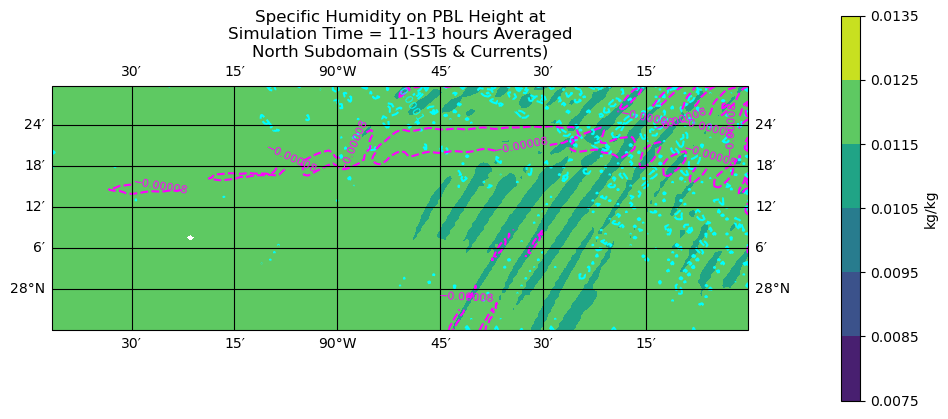

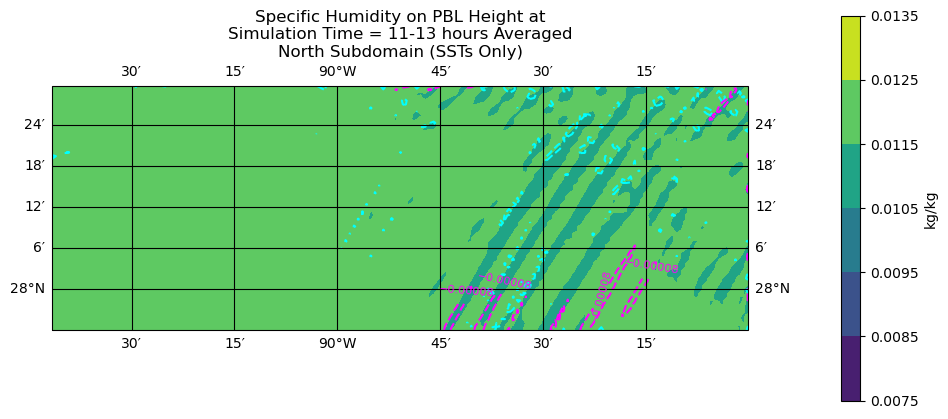

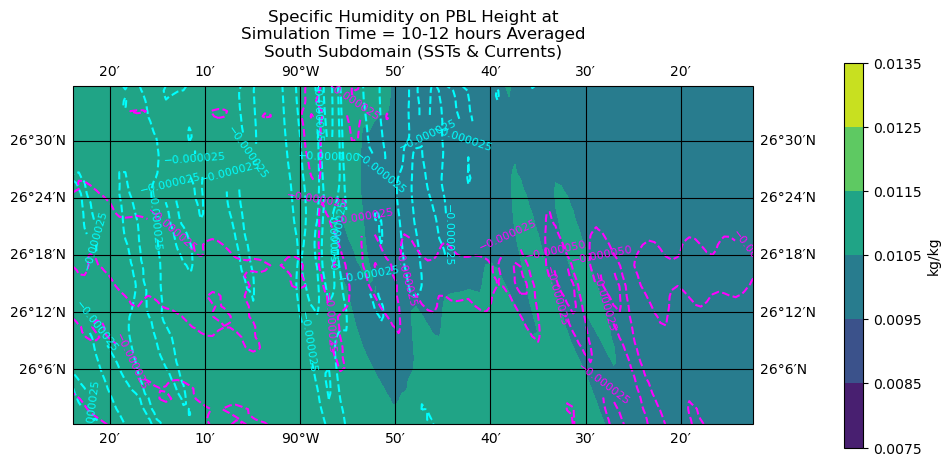

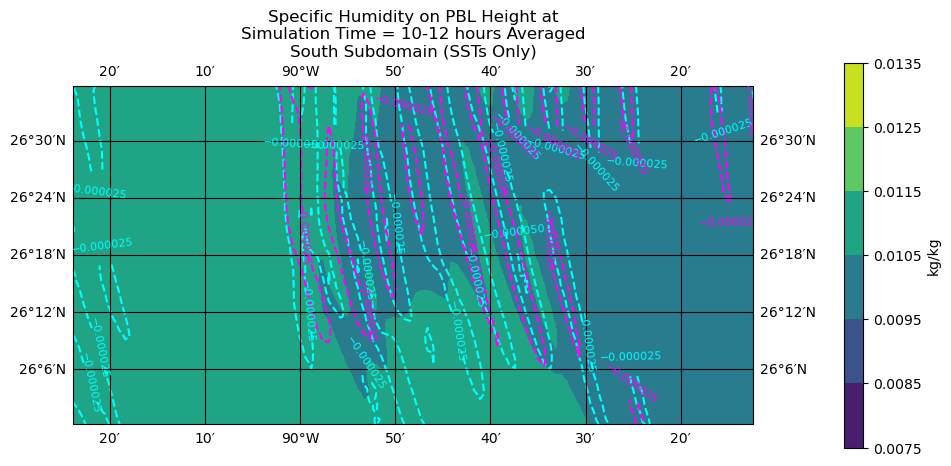

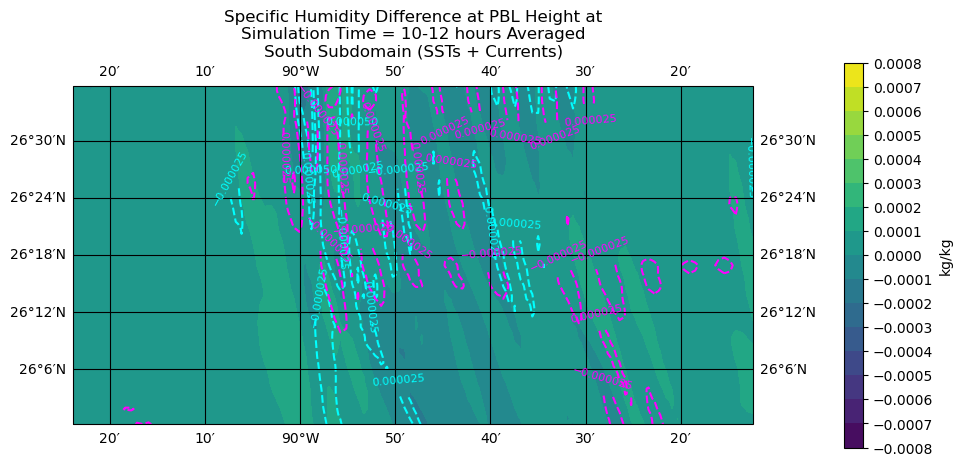

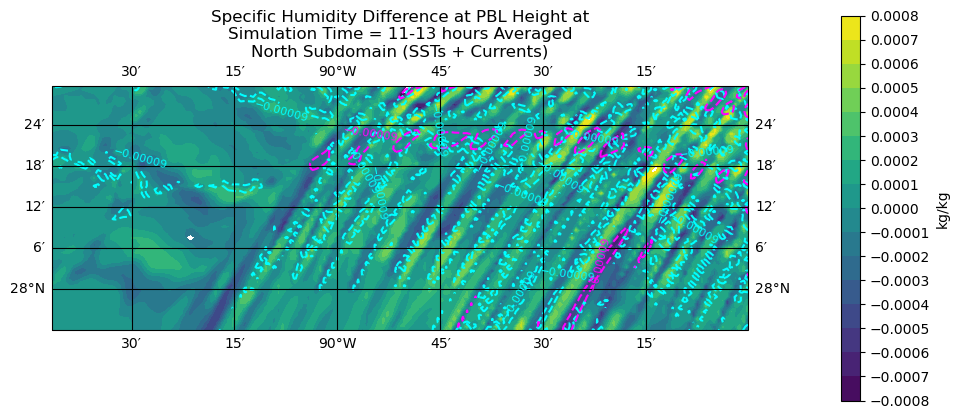

In [19]:
#AVG

vort_bounds_pblh_N = [ 0.0001, 0.0003, 0.0006]
vort_bounds_sfc_N = [-0.00016, -0.00008]

vort_bounds_pblh_S = [-0.0002, -0.0001, -0.00005, -0.000025]
vort_bounds_sfc_S = [-0.001, -0.00005, -0.000025]

vort_bounds_diff_S = [-0.003, -0.001 -0.00005, -0.000025, 0.000025, 0.00005, 0.001, 0.003]
vort_bounds_diff_N = [ -0.001, -0.00009, 0.0009, 0.001]

#PLOT w at PBLH 
#CUR north 
bounds = [0.0075, 0.0085, 0.0095, 0.0105, 0.0115, 0.0125, 0.0135]
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#PBLH VORT
cs1 = ax.contour(north_lon, north_lat, cur_curl_N_pblh, levels= vort_bounds_pblh_N, linestyles = "dashed", colors = 'cyan')
ax.clabel(cs1, inline=True, fontsize=8)
#SFC VORT
cs2 = ax.contour(north_lon, north_lat, cur_curl10_N, levels = vort_bounds_sfc_N, linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(north_lon, north_lat, cur_north_avg_qv, levels = bounds)
#cs = ax.contourf(north_lon, north_lat, cur_north_avg_qv)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'kg/kg')
#plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, label = 'kg/kg')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Specific Humidity on PBL Height at\nSimulation Time = 11-13 hours Averaged\nNorth Subdomain (SSTs & Currents)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Qv/'
plt.savefig(save_results_to + 'north_qv@pblh_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#SST north
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#PBLH VORT
cs1 = ax.contour(north_lon, north_lat, sst_curl_N_pblh, levels = vort_bounds_pblh_N, linestyles = "dashed", colors = 'cyan')
ax.clabel(cs1, inline=True, fontsize=8)
#SFC VORT
cs2 = ax.contour(north_lon, north_lat, sst_curl10_N, levels = vort_bounds_sfc_N , linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(north_lon, north_lat, sst_north_avg_qv, levels = bounds)
#cs = ax.contourf(north_lon, north_lat, sst_north_avg_qv)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'kg/kg')
#plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, label = 'kg/kg')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Specific Humidity on PBL Height at\nSimulation Time = 11-13 hours Averaged\nNorth Subdomain (SSTs Only)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Qv/'
plt.savefig(save_results_to + 'north_qv@pblh_sst.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#CUR south 
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#PBLH VORT
cs1 = ax.contour(south_lon, south_lat, cur_curl_S_pblh, levels = vort_bounds_pblh_S , linestyles = "dashed", colors = 'cyan')
ax.clabel(cs1, inline=True, fontsize=8)
#SFC VORT
cs2 = ax.contour(south_lon, south_lat, cur_curl10_S, levels = vort_bounds_sfc_S , linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(south_lon, south_lat, cur_south_avg_qv, levels = bounds)
#cs = ax.contourf(south_lon, south_lat, cur_south_avg_qv)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'kg/kg')
#plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, label = 'kg/kg')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Specific Humidity on PBL Height at\nSimulation Time = 10-12 hours Averaged\nSouth Subdomain (SSTs & Currents)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Qv/'
plt.savefig(save_results_to + 'south_qv@pblh_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#SST South 
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#PBLH VORT
cs1 = ax.contour(south_lon, south_lat, sst_curl_S_pblh, levels = vort_bounds_pblh_S , linestyles = "dashed", colors = 'cyan')
ax.clabel(cs1, inline=True, fontsize=8)
#SFC VORT
cs2 = ax.contour(south_lon, south_lat, sst_curl10_S, levels = vort_bounds_sfc_S , linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(south_lon, south_lat, sst_south_avg_qv, levels = bounds)
#cs = ax.contourf(south_lon, south_lat, sst_south_avg_qv)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'kg/kg')
#plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, label = 'kg/kg')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Specific Humidity on PBL Height at\nSimulation Time = 10-12 hours Averaged\nSouth Subdomain (SSTs Only)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Qv/'
plt.savefig(save_results_to + 'south_qv@pblh_sst.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#S diff
bounds = [-0.0008, -0.0007, -0.0006, -0.0005, -0.0004, -0.0003, -0.0002, -0.00010, 0, 0.00010, 0.00020, 0.0003,  0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#PBLH VORT
cs1 = ax.contour(south_lon, south_lat, S_pblh_diff, levels = vort_bounds_diff_S, linestyles = "dashed", colors = 'cyan')
ax.clabel(cs1, inline=True, fontsize=8)
#SFC VORT
cs2 = ax.contour(south_lon, south_lat, S_sfc_diff, levels = vort_bounds_diff_S, linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(south_lon, south_lat, S_qv_diff, levels = bounds)
#cs = ax.contourf(south_lon, south_lat, S_qv_diff)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'kg/kg')
#plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, label = 'kg/kg')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Specific Humidity Difference at PBL Height at\nSimulation Time = 10-12 hours Averaged\nSouth Subdomain (SSTs + Currents)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Qv/'
plt.savefig(save_results_to + 'south_qv@pblh_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#N diff 
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#PBLH VORT
cs1 = ax.contour(north_lon, north_lat, N_pblh_diff, levels = vort_bounds_diff_N, linestyles = "dashed", colors = 'cyan')
ax.clabel(cs1, inline=True, fontsize=8)
#SFC VORT
cs2 = ax.contour(north_lon, north_lat, N_sfc_diff, levels = vort_bounds_diff_N, linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(north_lon, north_lat, N_qv_diff, levels = bounds)
#cs = ax.contourf(north_lon, north_lat, N_qv_diff)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'kg/kg')
#plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, label = 'kg/kg')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Specific Humidity Difference at PBL Height at\nSimulation Time = 11-13 hours Averaged\nNorth Subdomain (SSTs + Currents)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Qv/'
plt.savefig(save_results_to + 'north_qv@pblh_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()



In [15]:
#AVG
sst_north_avg_qv_free = np.mean( np.array([sst_qv11_free_north ,sst_qv12_free_north, sst_qv13_free_north]), axis=0 )
sst_south_avg_qv_free = np.mean( np.array([sst_qv10_free_south ,sst_qv11_free_south, sst_qv12_free_south]), axis=0 )
cur_north_avg_qv_free = np.mean( np.array([cur_qv11_free_north ,cur_qv12_free_north, cur_qv13_free_north]), axis=0 )
cur_south_avg_qv_free = np.mean( np.array([cur_qv10_free_south ,cur_qv11_free_south, cur_qv12_free_south]), axis=0 )

N_qvFree_diff = cur_north_avg_qv_free - sst_north_avg_qv_free
S_qvFree_diff = cur_south_avg_qv_free - sst_south_avg_qv_free

print('SST N:')
print(np.nanmax(sst_north_avg_qv_free))
print(np.nanmin(sst_north_avg_qv_free))
print('CUR N:')
print(np.nanmax(cur_north_avg_qv_free))
print(np.nanmin(cur_north_avg_qv_free))
print('SST S:')
print(np.max(sst_south_avg_qv_free))
print(np.min(sst_south_avg_qv_free))
print('CUR S:')
print(np.max(cur_south_avg_qv_free))
print(np.min(cur_south_avg_qv_free))
print('diff N:')
print(np.nanmax(N_qvFree_diff))
print(np.nanmin(N_qvFree_diff))
print('diff S:')
print(np.max(S_qvFree_diff))
print(np.min(S_qvFree_diff))


print(' ')
sst_north_avg_qv_free_flat = sst_north_avg_qv.flatten()
cur_north_avg_qv_free_flat = cur_north_avg_qv.flatten()
sst_south_avg_qv_free_flat = sst_south_avg_qv.flatten()
cur_south_avg_qv_free_flat = cur_south_avg_qv.flatten()
sst_N_mean_free = np.nanmean(sst_north_avg_qv_free_flat)
cur_N_mean_free = np.nanmean(cur_north_avg_qv_free_flat)
sst_S_mean_free = np.nanmean(sst_south_avg_qv_free_flat)
cur_S_mean_free = np.nanmean(cur_south_avg_qv_free_flat)
print(' ')
print('sst_N_mean: ', sst_N_mean_free)
print('cur_N_mean: ', cur_N_mean_free)
print('sst_S_mean: ', sst_S_mean_free)
print('cur_S_mean: ', cur_S_mean_free)
sst_N_std_free = np.nanstd(sst_north_avg_qv_free_flat)
cur_N_std_free = np.nanstd(cur_north_avg_qv_free_flat)
sst_S_std_free = np.nanstd(sst_south_avg_qv_free_flat)
cur_S_std_free = np.nanstd(cur_south_avg_qv_free_flat)
print(' ')
print('sst_N_std: ', sst_N_std_free)
print('cur_N_std: ', cur_N_std_free)
print('sst_S_std: ', sst_S_std_free)
print('cur_S_std: ', cur_S_std_free)

print(' ')
N_diff_mean_free = cur_N_mean_free - sst_N_mean_free
S_diff_mean_free = cur_S_mean_free - sst_S_mean_free
N_diff_std_free = cur_N_std_free - sst_N_std_free
S_diff_std_free = cur_S_std_free - sst_S_std_free
print('N_diff_mean: ', N_diff_mean)
print('S_diff_mean: ', S_diff_mean)
print('N_diff_std: ', N_diff_std)
print('S_diff_std: ', S_diff_std)

print(' ')
sst_N_mean_uncert_free = sst_N_std_free /np.sqrt(n_N) 
cur_N_mean_uncert_free = cur_N_std_free /np.sqrt(n_N) 
sst_S_mean_uncert_free = sst_S_std_free /np.sqrt(n_S) 
cur_S_mean_uncert_free = cur_S_std_free /np.sqrt(n_S) 
print('sst_N_mean_uncert: ', sst_N_mean_uncert_free)
print('cur_N_mean_uncert: ', cur_N_mean_uncert_free)
print('sst_S_mean_uncert: ', sst_S_mean_uncert_free)
print('cur_S_mean_uncert: ', cur_S_mean_uncert_free)

print(' ')
N_diff_mean_uncert_free = np.sqrt( ((cur_N_std_free**2)/n_N) + ((sst_N_std_free**2)/n_N) )
S_diff_mean_uncert_free = np.sqrt( ((cur_S_std_free**2)/n_S) + ((sst_S_std_free**2)/n_S) )
print('N_diff_mean_uncert: ', N_diff_mean_uncert_free)
print('S_diff_mean_uncert: ', S_diff_mean_uncert_free)

SST N:
0.0059607383
0.001087124
CUR N:
0.00532175
0.0010884218
SST S:
0.0011863386
0.0006654598
CUR S:
0.0011949226
0.00067761383
diff N:
0.0027564527
-0.0018467659
diff S:
3.5541598e-05
-1.3926765e-05
 
 
sst_N_mean:  0.011848903
cur_N_mean:  0.011860981
sst_S_mean:  0.010552704
cur_S_mean:  0.010592626
 
sst_N_std:  0.00027408628
cur_N_std:  0.00026572644
sst_S_std:  0.00025924618
cur_S_std:  0.00025778374
 
N_diff_mean:  1.2077391e-05
S_diff_mean:  3.9922073e-05
N_diff_std:  -8.3598425e-06
S_diff_std:  -1.4624384e-06
 
sst_N_mean_uncert:  2.5911446946502348e-06
cur_N_mean_uncert:  2.5121127884832245e-06
sst_S_mean_uncert:  2.915640436660325e-06
cur_S_mean_uncert:  2.8991929641166437e-06
 
N_diff_mean_uncert:  3.608980671973046e-06
S_diff_mean_uncert:  4.1117245772391255e-06


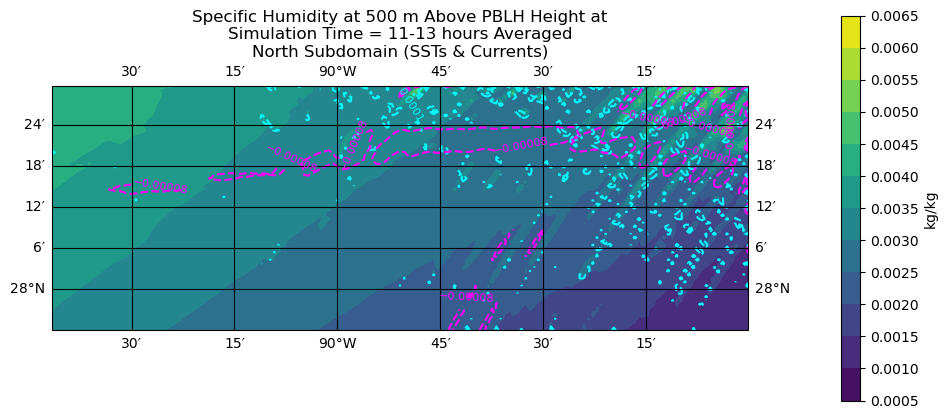

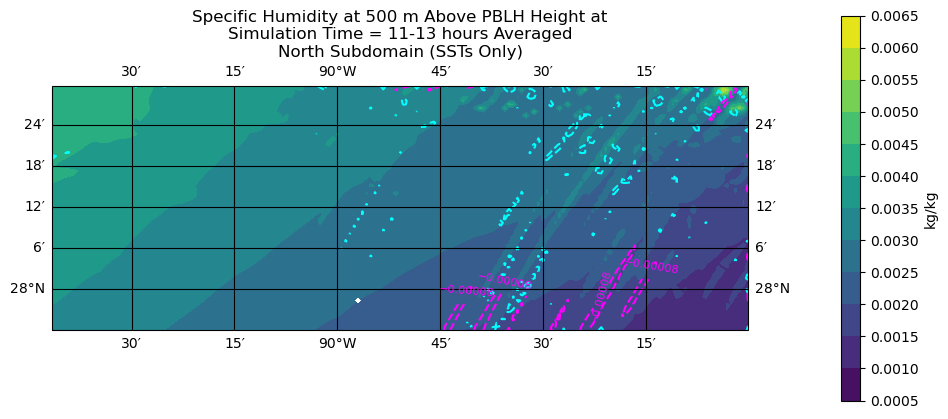

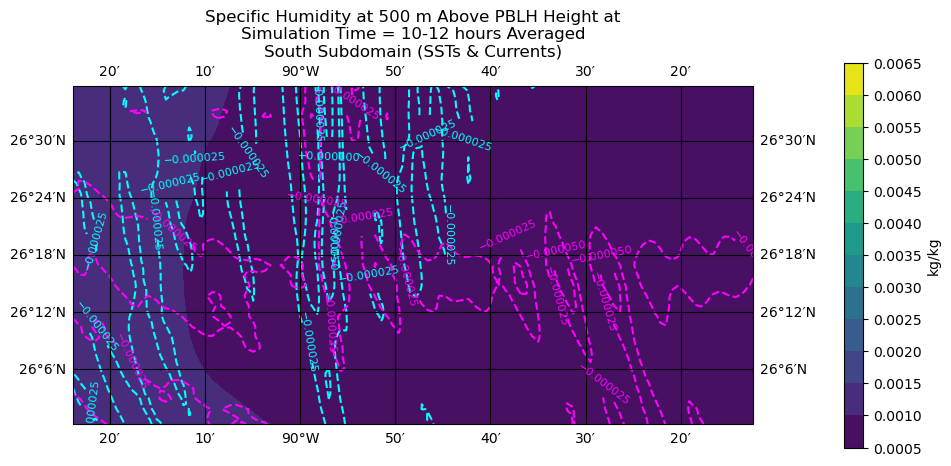

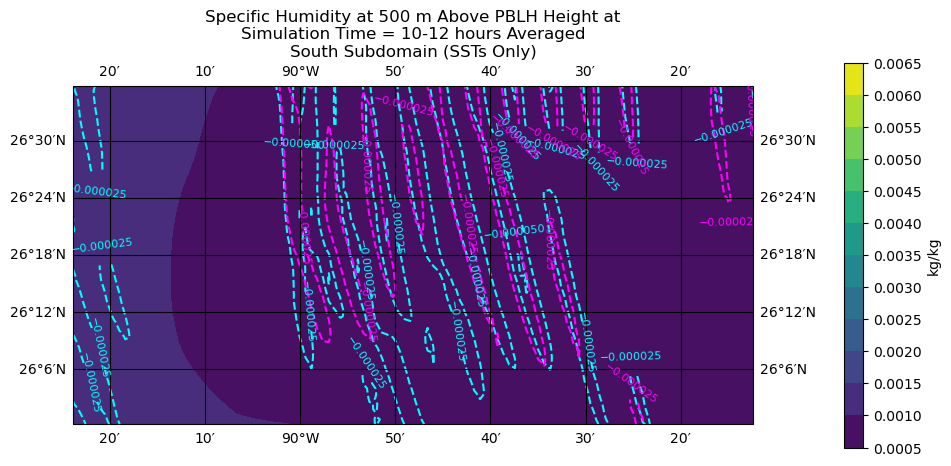

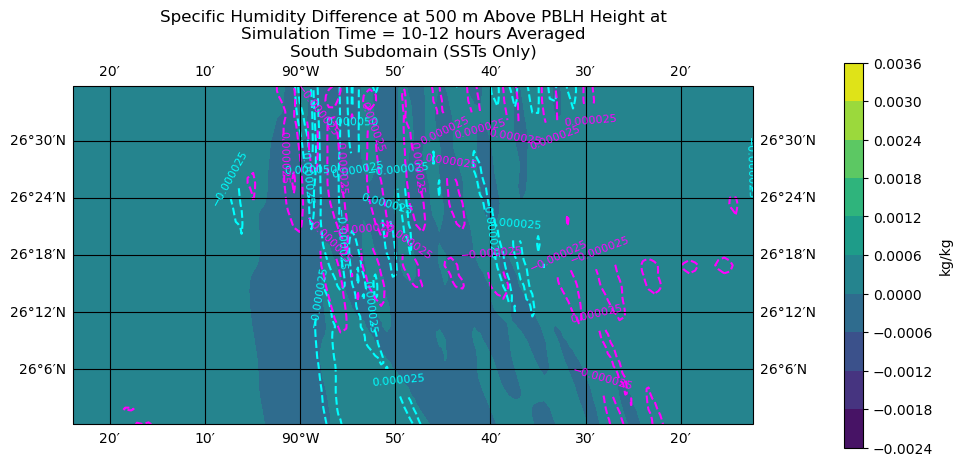

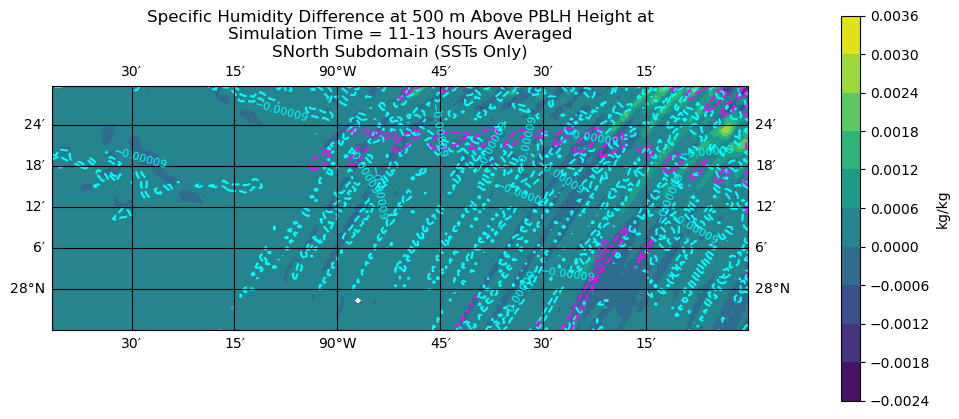

In [27]:

#PLOT w at PBLH 
bounds = [0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.0065]
#CUR NORTH
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#PBLH VORT
cs1 = ax.contour(north_lon, north_lat, cur_curl_N_pblh, levels= vort_bounds_pblh_N, linestyles = "dashed", colors = 'cyan')
ax.clabel(cs1, inline=True, fontsize=8)
#SFC VORT
cs2 = ax.contour(north_lon, north_lat, cur_curl10_N, levels = vort_bounds_sfc_N, linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(north_lon, north_lat, cur_north_avg_qv_free, levels = bounds)
#cs = ax.contourf(north_lon, north_lat, cur_north_avg_qv_free)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'kg/kg')
#plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, label = 'kg/kg')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Specific Humidity at 500 m Above PBLH Height at\nSimulation Time = 11-13 hours Averaged\nNorth Subdomain (SSTs & Currents)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Qv/'
plt.savefig(save_results_to + 'north_qv@free_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#SST NORTH
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#PBLH VORT
cs1 = ax.contour(north_lon, north_lat, sst_curl_N_pblh, levels = vort_bounds_pblh_N, linestyles = "dashed", colors = 'cyan')
ax.clabel(cs1, inline=True, fontsize=8)
#SFC VORT
cs2 = ax.contour(north_lon, north_lat, sst_curl10_N, levels = vort_bounds_sfc_N , linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(north_lon, north_lat, sst_north_avg_qv_free, levels = bounds)
#cs = ax.contourf(north_lon, north_lat, sst_north_avg_qv_free)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'kg/kg')
#plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, label = 'kg/kg')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Specific Humidity at 500 m Above PBLH Height at\nSimulation Time = 11-13 hours Averaged\nNorth Subdomain (SSTs Only)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Qv/'
plt.savefig(save_results_to + 'north_qv@free_sst.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#CUR SOUTH
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#PBLH VORT
cs1 = ax.contour(south_lon, south_lat, cur_curl_S_pblh, levels = vort_bounds_pblh_S , linestyles = "dashed", colors = 'cyan')
ax.clabel(cs1, inline=True, fontsize=8)
#SFC VORT
cs2 = ax.contour(south_lon, south_lat, cur_curl10_S, levels = vort_bounds_sfc_S , linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(south_lon, south_lat, cur_south_avg_qv_free, levels = bounds)
#cs = ax.contourf(south_lon, south_lat, cur_south_avg_qv_free)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'kg/kg')
#plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, label = 'kg/kg')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Specific Humidity at 500 m Above PBLH Height at\nSimulation Time = 10-12 hours Averaged\nSouth Subdomain (SSTs & Currents)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Qv/'
plt.savefig(save_results_to + 'south_qv@free_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#SST SOUTH
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#PBLH VORT
cs1 = ax.contour(south_lon, south_lat, sst_curl_S_pblh, levels = vort_bounds_pblh_S , linestyles = "dashed", colors = 'cyan')
ax.clabel(cs1, inline=True, fontsize=8)
#SFC VORT
cs2 = ax.contour(south_lon, south_lat, sst_curl10_S, levels = vort_bounds_sfc_S , linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(south_lon, south_lat, sst_south_avg_qv_free, levels = bounds)
#cs = ax.contourf(south_lon, south_lat, sst_south_avg_qv_free)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'kg/kg')
#plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, label = 'kg/kg')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Specific Humidity at 500 m Above PBLH Height at\nSimulation Time = 10-12 hours Averaged\nSouth Subdomain (SSTs Only)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Qv/'
plt.savefig(save_results_to + 'south_qv@free_sst.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#SOUTH DIFF
bounds= [-0.0024, -0.0018, -0.0012, -0.0006, 0, 0.0006, 0.0012, 0.0018, 0.0024, 0.003, 0.0036]
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#PBLH VORT
cs1 = ax.contour(south_lon, south_lat, S_pblh_diff, levels = vort_bounds_diff_S, linestyles = "dashed", colors = 'cyan')
ax.clabel(cs1, inline=True, fontsize=8)
#SFC VORT
cs2 = ax.contour(south_lon, south_lat, S_sfc_diff, levels = vort_bounds_diff_S, linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(south_lon, south_lat, S_qvFree_diff, levels = bounds)
#cs = ax.contourf(south_lon, south_lat, S_qvFree_diff)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'kg/kg')
#plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, label = 'kg/kg')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Specific Humidity Difference at 500 m Above PBLH Height at\nSimulation Time = 10-12 hours Averaged\nSouth Subdomain (SSTs Only)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Qv/'
plt.savefig(save_results_to + 'south_qv@free_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#NORTH DIFF 
#bounds= []
mapcrs = crs.PlateCarree()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=mapcrs)
#PBLH VORT
cs1 = ax.contour(north_lon, north_lat, N_pblh_diff, levels = vort_bounds_diff_N, linestyles = "dashed", colors = 'cyan')
ax.clabel(cs1, inline=True, fontsize=8)
#SFC VORT
cs2 = ax.contour(north_lon, north_lat, N_sfc_diff, levels = vort_bounds_diff_N, linestyles = "dashed", colors = 'magenta')
ax.clabel(cs2, inline=True, fontsize=8)
ax.coastlines()
cs = ax.contourf(north_lon, north_lat, N_qvFree_diff, levels = bounds)
#cs = ax.contourf(north_lon, north_lat, N_qvFree_diff)
PCM=ax.get_children()[2]
plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, ticks = bounds, label = 'kg/kg')
#plt.colorbar(cs, ax=ax, shrink = 0.5, pad =0.1, label = 'kg/kg')
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color = 'black')
plt.tight_layout()
gl.top_labels = False
gl.ylabels_right = False
plt.title('Specific Humidity Difference at 500 m Above PBLH Height at\nSimulation Time = 11-13 hours Averaged\nSNorth Subdomain (SSTs Only)')
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Qv/'
plt.savefig(save_results_to + 'south_qv@free_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()


In [16]:
#vert cross: qv and Tv
#step 1: average 1, 2 and keep 0
#step 2: plot cross section 
    #cross north = 89.2W, 27.9-28.5N
    #cros south = 89.9W, 26.0-26.6N (to include DS data)
#step: add PBLH line

sst_tv_south = (sst_tv_10 + sst_tv_11 + sst_tv_12)/3
sst_tv_north = (sst_tv_11 + sst_tv_12 + sst_tv_13)/3
cur_tv_south = (cur_tv_10 + cur_tv_11 + cur_tv_12)/3
cur_tv_north = (cur_tv_11 + cur_tv_12 + cur_tv_13)/3

sst_qv_south = (sst_qv10 + sst_qv11 + sst_qv12)/3
sst_qv_north = (sst_qv11 + sst_qv12 + sst_qv13)/3
cur_qv_south = (cur_qv10 + cur_qv11 + cur_qv12)/3
cur_qv_north = (cur_qv11 + cur_qv12 + cur_qv13)/3

cur_z10 = getvar(cur_wrfout10, "z")
cur_z11 = getvar(cur_wrfout11, "z")
cur_z12 = getvar(cur_wrfout12, "z")
cur_z13 = getvar(cur_wrfout13, "z")

sst_z10 = getvar(sst_wrfout10, "z")
sst_z11 = getvar(sst_wrfout11, "z")
sst_z12 = getvar(sst_wrfout12, "z")
sst_z13 = getvar(sst_wrfout13, "z")

z_sst_south = (sst_z10 + sst_z11 +sst_z12)/3
z_cur_south = (cur_z10 + cur_z11 +cur_z12)/3
z_sst_north = (sst_z11 + sst_z12 +sst_z13)/3
z_cur_north = (cur_z11 + sst_z12 +sst_z13)/3

In [19]:
print('SST N:')
print(np.nanmax(sst_tv_north))
print(np.nanmin(sst_tv_north))
print('CUR N:')
print(np.nanmax(cur_tv_north))
print(np.nanmin(cur_tv_north))
print('SST S:')
print(np.max(sst_tv_south))
print(np.min(sst_tv_south))
print('CUR S:')
print(np.max(cur_tv_south))
print(np.min(cur_tv_south))
print('diff N:')
print(np.nanmax(cur_tv_north - sst_tv_north))
print(np.nanmin(cur_tv_north - sst_tv_north))
print('diff S:')
print(np.max(cur_tv_south - sst_tv_south))
print(np.min(cur_tv_south - sst_tv_south))

print(sst_tv_north.shape)

SST N:
476.26425
287.29807
CUR N:
476.26465
287.41718
SST S:
<xarray.DataArray 'tvirtual' ()>
array(476.17834473)
<xarray.DataArray 'tvirtual' ()>
array(287.46029663)
CUR S:
<xarray.DataArray 'tvirtual' ()>
array(476.17764282)
<xarray.DataArray 'tvirtual' ()>
array(287.45761108)
diff N:
1.0230408
-0.99920654
diff S:
<xarray.DataArray 'tvirtual' ()>
array(0.95458984)
<xarray.DataArray 'tvirtual' ()>
array(-0.98779297)
(99, 474, 639)


In [21]:
print(' ')
#sst_tv_north = sst_tv_north.flatten()
#cur_tv_north = cur_tv_north.flatten()
#sst_tv_south = sst_tv_south.flatten()
#cur_tv_south = cur_tv_south.flatten()
sst_tv_north_mean = np.nanmean(sst_tv_north)
cur_tv_north_mean = np.nanmean(cur_tv_north)
sst_tv_south_mean = np.nanmean(sst_tv_south)
cur_tv_south_mean = np.nanmean(cur_tv_south)
print(' ')
print('sst_N_mean: ', sst_tv_north_mean )
print('cur_N_mean: ', cur_tv_north_mean)
print('sst_S_mean: ', sst_tv_couth_mean )
print('cur_S_mean: ', cur_tv_south_mean)
sst_N_std_tv = np.nanstd(sst_tv_north)
cur_N_std_tv = np.nanstd(cur_tv_north)
sst_S_std_tv = np.nanstd(sst_tv_south)
cur_S_std_tv = np.nanstd(cur_tv_south)
print(' ')
print('sst_N_std: ', sst_N_std_tv)
print('cur_N_std: ', cur_N_std_tv)
print('sst_S_std: ', sst_S_std_tv)
print('cur_S_std: ', cur_S_std_tv)

print(' ')
N_diff_mean_tv = cur_tv_north_mean - sst_tv_north_mean
S_diff_mean_tv = cur_tv_south_mean - sst_tv_south_mean
N_diff_std_tv = cur_N_std_tv- sst_N_std_tv
S_diff_std_tv = cur_S_std_tv- sst_S_std_tv
print('N_diff_mean: ', N_diff_mean_tv)
print('S_diff_mean: ', S_diff_mean_tv)
print('N_diff_std: ', N_diff_std_tv)
print('S_diff_std: ', S_diff_std_tv)

print(' ')
sst_N_mean_uncert_tv = sst_N_std_tv /np.sqrt(n_N) 
cur_N_mean_uncert_tv = cur_N_std_tv /np.sqrt(n_N) 
sst_S_mean_uncert_tv = sst_S_std_tv /np.sqrt(n_S) 
cur_S_mean_uncert_tv = cur_S_std_tv /np.sqrt(n_S) 
print('sst_N_mean_uncert: ', sst_N_mean_uncert_tv)
print('cur_N_mean_uncert: ', cur_N_mean_uncert_tv)
print('sst_S_mean_uncert: ', sst_S_mean_uncert_tv)
print('cur_S_mean_uncert: ', cur_S_mean_uncert_tv)

print(' ')
N_diff_mean_uncert_tv = np.sqrt( ((cur_N_std_tv**2)/n_N) + ((sst_N_std_tv**2)/n_N) )
S_diff_mean_uncert_tv = np.sqrt( ((cur_S_std_tv**2)/n_S) + ((sst_S_std_tv**2)/n_S) )
print('N_diff_mean_uncert: ', N_diff_mean_uncert_tv)
print('S_diff_mean_uncert: ', S_diff_mean_uncert_tv)

 
 
sst_N_mean:  340.50107
cur_N_mean:  340.50125
sst_S_mean:  340.6153
cur_S_mean:  340.6152
 
sst_N_std:  47.146183
cur_N_std:  47.14606
sst_S_std:  47.209053
cur_S_std:  47.209095
 
N_diff_mean:  0.00018310547
S_diff_mean:  -9.1552734e-05
N_diff_std:  -0.00012207031
S_diff_std:  4.196167e-05
 
sst_N_mean_uncert:  0.44570848390116286
cur_N_mean_uncert:  0.44570732987828265
sst_S_mean_uncert:  0.5309417587054653
cur_S_mean_uncert:  0.530942230631958
 
N_diff_mean_uncert:  0.6303261667808988
S_diff_mean_uncert:  0.7508653696939898


In [14]:
#Get PBLH line
cur_pblh_north = np.mean( np.array([ cur_pblh_11, cur_pblh_12, cur_pblh_13 ]), axis=0 )
cur_pblh_south = np.mean( np.array([ cur_pblh_10, cur_pblh_11, cur_pblh_12 ]), axis=0 )
sst_pblh_north = np.mean( np.array([ sst_pblh_11, sst_pblh_12, sst_pblh_13 ]), axis=0 )
sst_pblh_south = np.mean( np.array([ sst_pblh_10, sst_pblh_11, sst_pblh_12 ]), axis=0 )
print(sst_pblh_south.shape)

lon_south = np.where(xlon[400,:]==-89.2)

lat1_south = np.where(xlat[:,400]>=26.0)
lat2_south = np.where(xlat[:,400]<=26.6)
lat_int_south = np.intersect1d(lat1_south, lat2_south)

lon_north = np.where(xlon[400,:]==-89.9)

lat1_north = np.where(xlat[:,400]>=27.9)
lat2_north = np.where(xlat[:,400]<=28.5)
lat_int_north = np.intersect1d(lat1_north, lat2_north)

new_south_pblh_sst = []
for y in lat_int_south:
    inner_sst = []
    for x in lon_south:
        inner_sst.append(sst_pblh_south[y][x])
    new_south_pblh_sst.append(inner_sst)
new_south_pblh_sst = np.array(new_south_pblh_sst)
print(new_south_pblh_sst.shape)

new_north_pblh_sst = []
for y in lat_int_north:
    inner_sst = []
    for x in lon_north:
        inner_sst.append(sst_pblh_north[y][x])
    new_north_pblh_sst.append(inner_sst)
new_north_pblh_sst = np.array(new_north_pblh_sst)
print(new_north_pblh_sst.shape)

new_south_pblh_cur = []
for y in lat_int_south:
    inner_cur = []
    for x in lon_south:
        inner_cur.append(cur_pblh_south[y][x])
    new_south_pblh_cur.append(inner_cur)
new_south_pblh_cur = np.array(new_south_pblh_cur)
print(new_south_pblh_cur.shape)

new_north_pblh_cur = []
for y in lat_int_north:
    inner_cur = []
    for x in lon_north:
        inner_cur.append(cur_pblh_north[y][x])
    new_north_pblh_cur.append(inner_cur)
new_north_pblh_cur = np.array(new_north_pblh_cur)
print(new_north_pblh_cur.shape)


(474, 639)
(67, 1, 0)
(67, 1, 0)
(67, 1, 0)
(67, 1, 0)


In [15]:
sst_tv_north = (sst_tv_11 + sst_tv_12 + sst_tv_13) /3
sst_tv_south = (sst_tv_10 + sst_tv_11 + sst_tv_12) /3
cur_tv_north = (cur_tv_11 + cur_tv_12 + cur_tv_13) /3
cur_tv_south = (cur_tv_10 + cur_tv_11 + cur_tv_12) /3

cur_z10 = getvar(cur_wrfout10, "z")
cur_z11 = getvar(cur_wrfout11, "z")
cur_z12 = getvar(cur_wrfout12, "z")
cur_z13 = getvar(cur_wrfout13, "z")

sst_z10 = getvar(sst_wrfout10, "z")
sst_z11 = getvar(sst_wrfout11, "z")
sst_z12 = getvar(sst_wrfout12, "z")
sst_z13 = getvar(sst_wrfout13, "z")

z_sst_south = (sst_z10 + sst_z11 +sst_z12)/3
z_cur_south = (cur_z10 + cur_z11 +cur_z12)/3
z_sst_north = (sst_z11 + sst_z12 +sst_z13)/3
z_cur_north = (cur_z11 + sst_z12 +sst_z13)/3

N_diff = cur_tv_north -sst_tv_north 
S_diff = cur_tv_south -sst_tv_south 


In [16]:
N_cur_pblh = (cur_pblh_11 + cur_pblh_12 +cur_pblh_13) /3
N_sst_pblh = (sst_pblh_11 + sst_pblh_12 +sst_pblh_13) /3
S_cur_pblh = (cur_pblh_10 + cur_pblh_11 +cur_pblh_12) /3
S_sst_pblh = (sst_pblh_10 + sst_pblh_11 +sst_pblh_12) /3

N_pblh_line_sst = wrf.interpline(field2d = N_sst_pblh, wrfin=cur_wrfout12, timeidx=0, stagger=None, projection=None, ll_point=None, pivot_point=None, angle=None, start_point=CoordPair(lat=28.5, lon=-89.1), end_point=CoordPair(lat=27.7, lon=-89.1), latlon=True, cache=None, meta=True)
S_pblh_line_sst = wrf.interpline(field2d = S_sst_pblh, wrfin=cur_wrfout12, timeidx=0, stagger=None, projection=None, ll_point=None, pivot_point=None, angle=None, start_point=CoordPair(lat=26.6, lon=-89.9), end_point=CoordPair(lat=26.0, lon=-89.9), latlon=True, cache=None, meta=True)
N_pblh_line_cur = wrf.interpline(field2d = N_cur_pblh, wrfin=cur_wrfout12, timeidx=0, stagger=None, projection=None, ll_point=None, pivot_point=None, angle=None, start_point=CoordPair(lat=28.5, lon=-89.1), end_point=CoordPair(lat=27.7, lon=-89.1), latlon=True, cache=None, meta=True)
S_pblh_line_cur = wrf.interpline(field2d = S_cur_pblh, wrfin=cur_wrfout12, timeidx=0, stagger=None, projection=None, ll_point=None, pivot_point=None, angle=None, start_point=CoordPair(lat=26.6, lon=-89.9), end_point=CoordPair(lat=26.0, lon=-89.9), latlon=True, cache=None, meta=True)

#print(N_pblh_line_sst.shape)
#print(S_pblh_line_sst.shape)
#print(N_pblh_line_cur.shape)
#print(S_pblh_line_cur.shape)

In [17]:
sst_qv_north = (sst_qv11 + sst_qv12 + sst_qv13) /3
sst_qv_south = (sst_qv10 + sst_qv11 + sst_qv12) /3
cur_qv_north = (cur_qv11 + cur_qv12 + cur_qv13) /3
cur_qv_south = (cur_qv10 + cur_qv11 + cur_qv12) /3
#print(np.max(sst_qv_north)) #0.01559238
#print(np.max(sst_qv_south)) #0.01538849
#print(np.max(cur_qv_north)) #0.0155968
#print(np.max(cur_qv_south)) #0.01539045
#print(np.min(sst_qv_north)) #9.9082888e-07
#print(np.min(sst_qv_south)) #9.90715648e-07
#print(np.min(cur_qv_north)) #9.9085014e-07
#print(np.min(cur_qv_south)) #9.90718377e-07

N_qv_diff = cur_qv_north -sst_qv_north 
S_qv_diff = cur_qv_south -sst_qv_south 
#print('Diff: ')
#print(np.max(N_qv_diff)) #0.00295248
#print(np.max(S_qv_diff)) #0.00295248
#print(np.min(N_qv_diff)) #-0.00272097
#print(np.min(S_qv_diff)) #-0.00308028

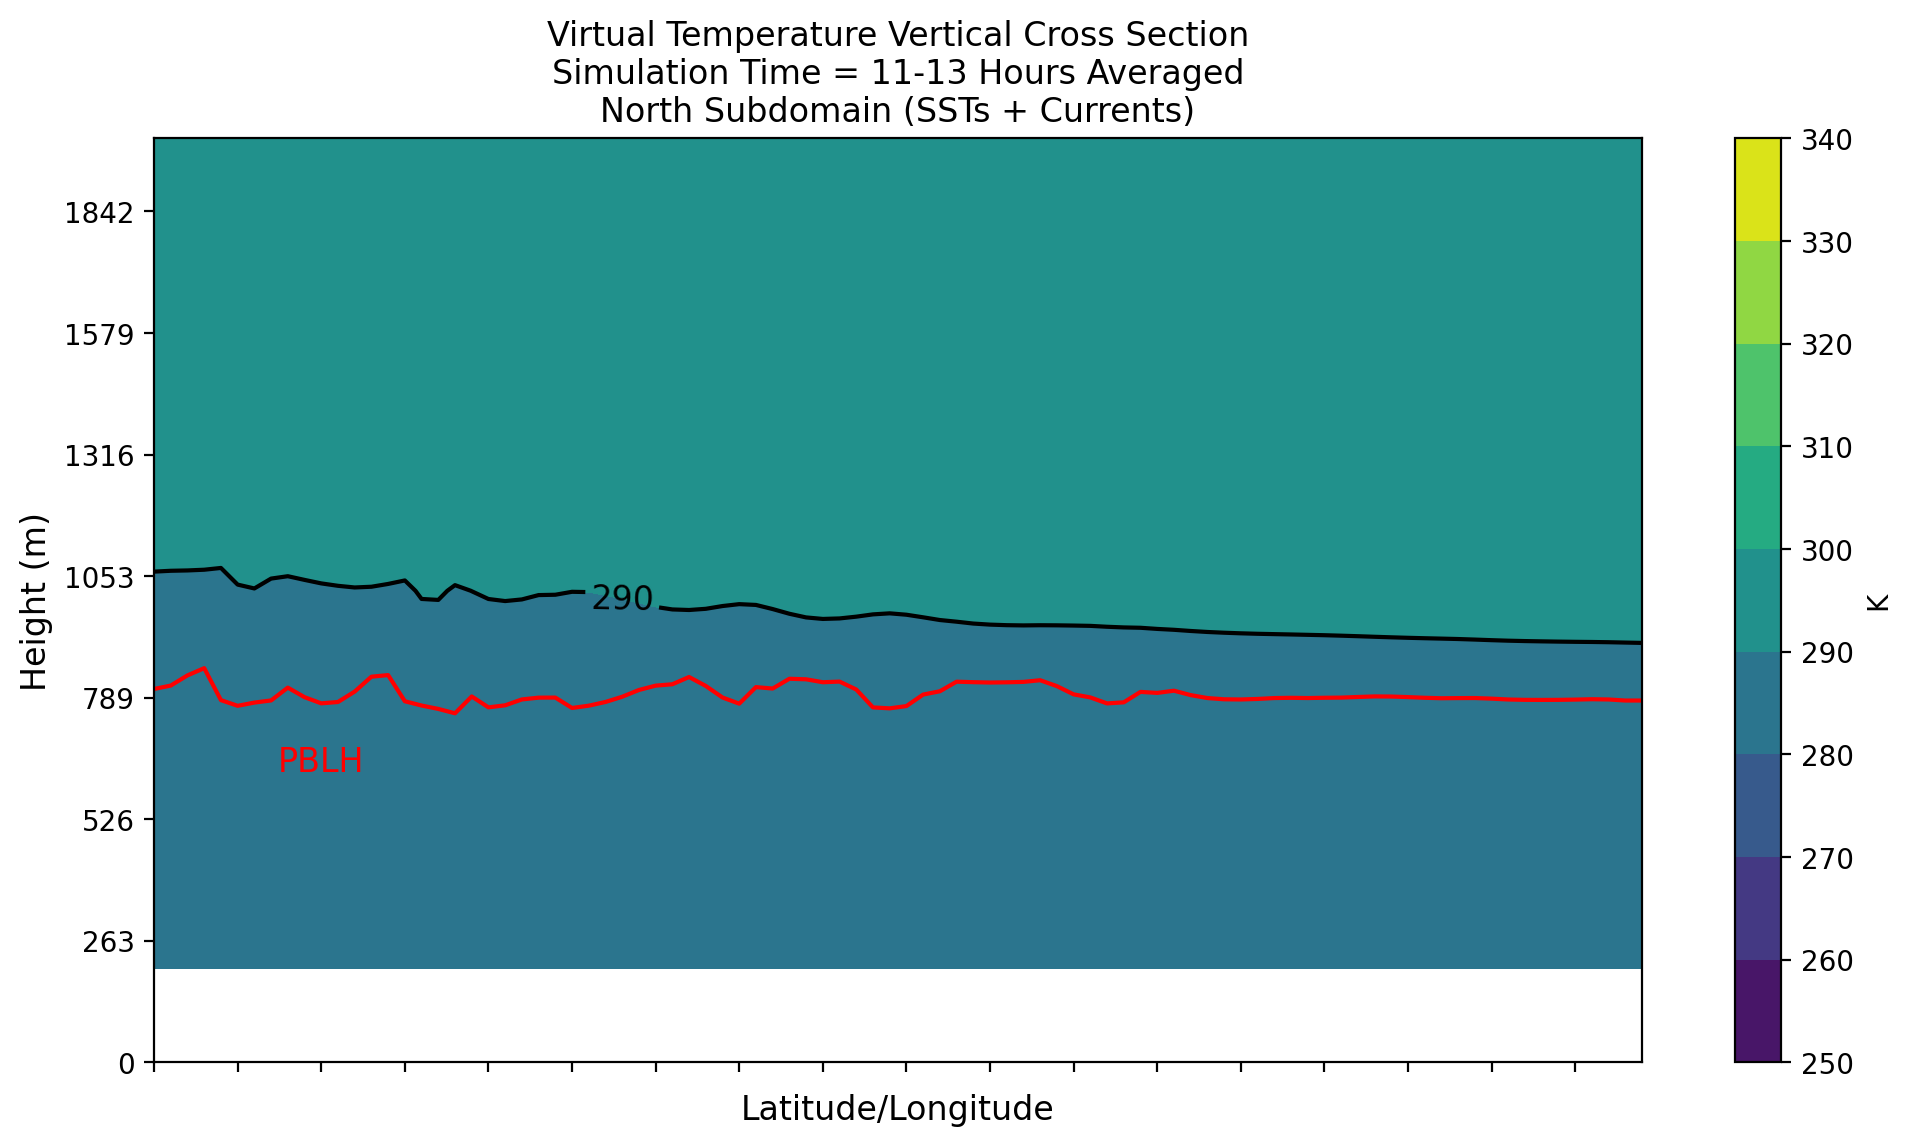

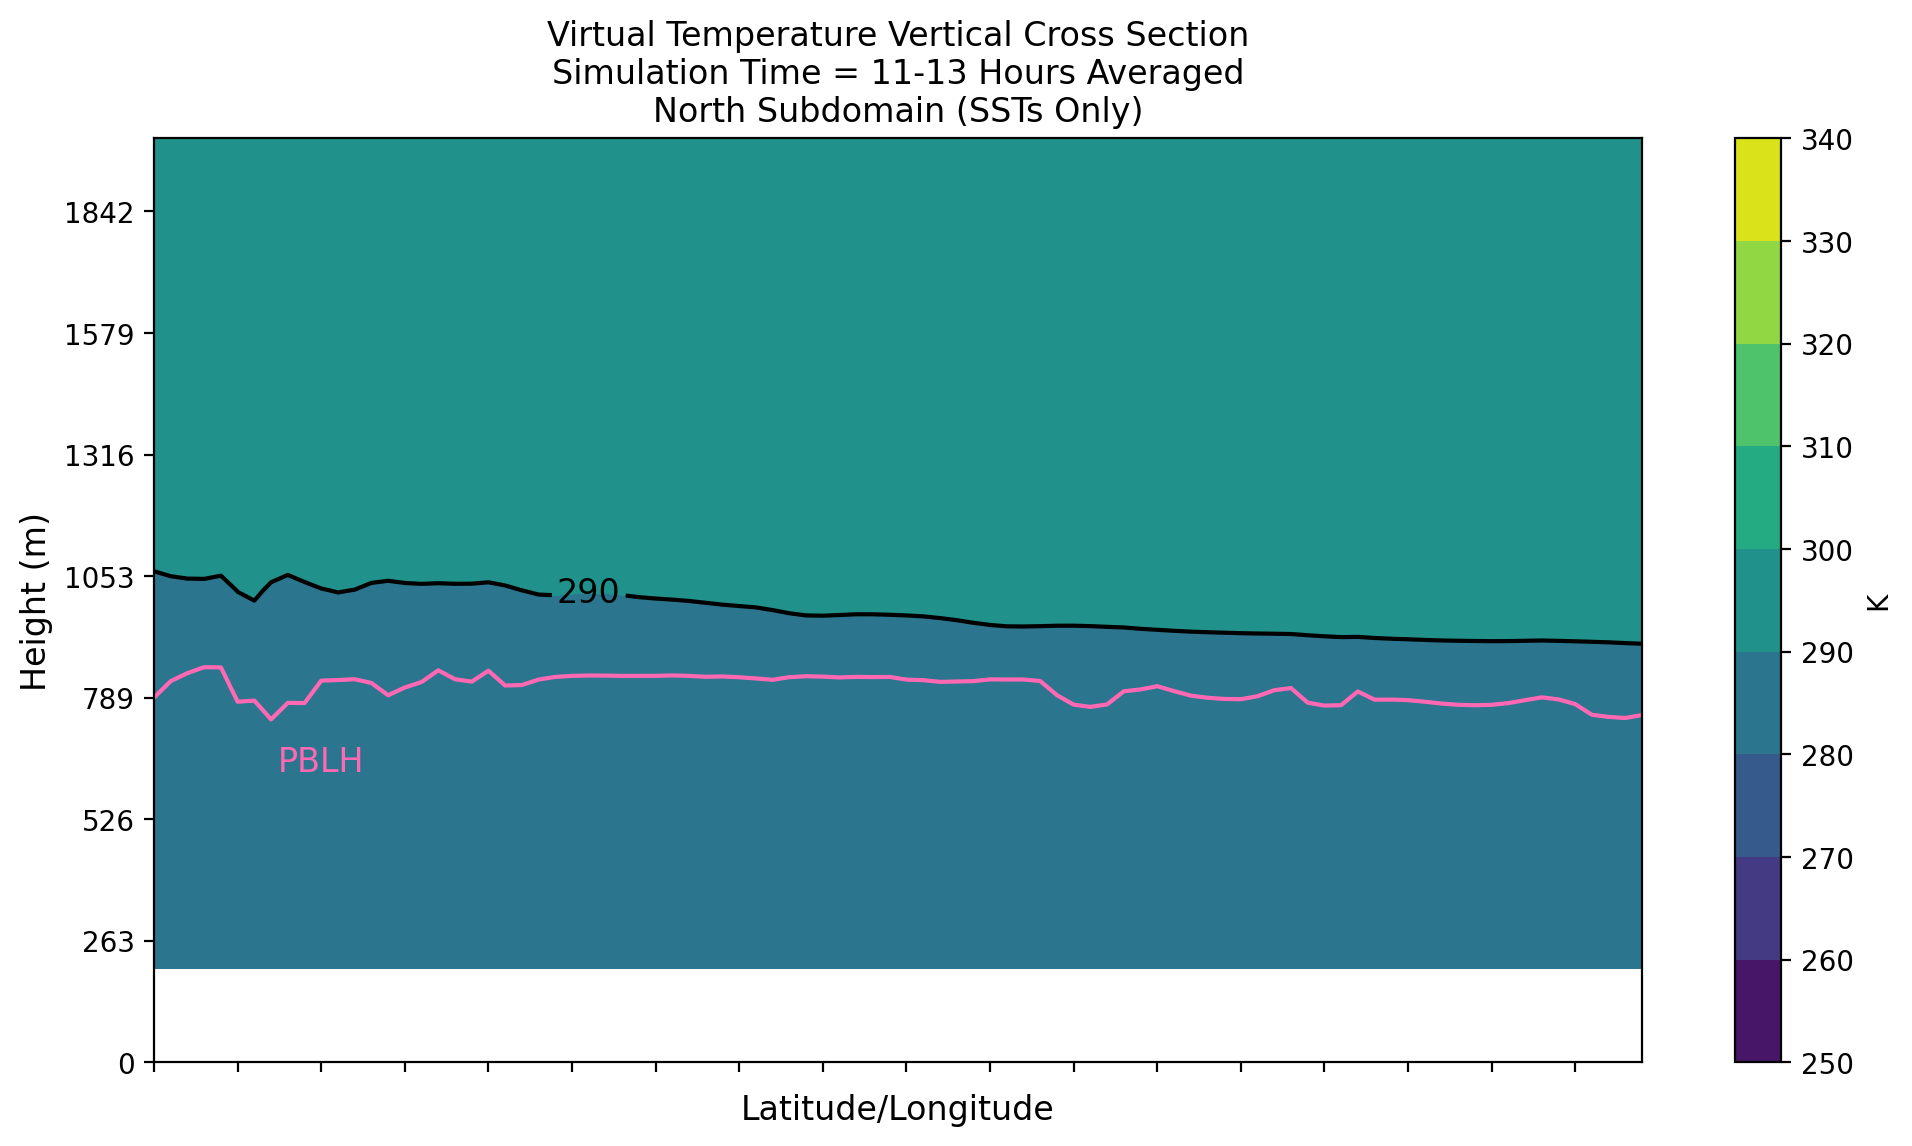

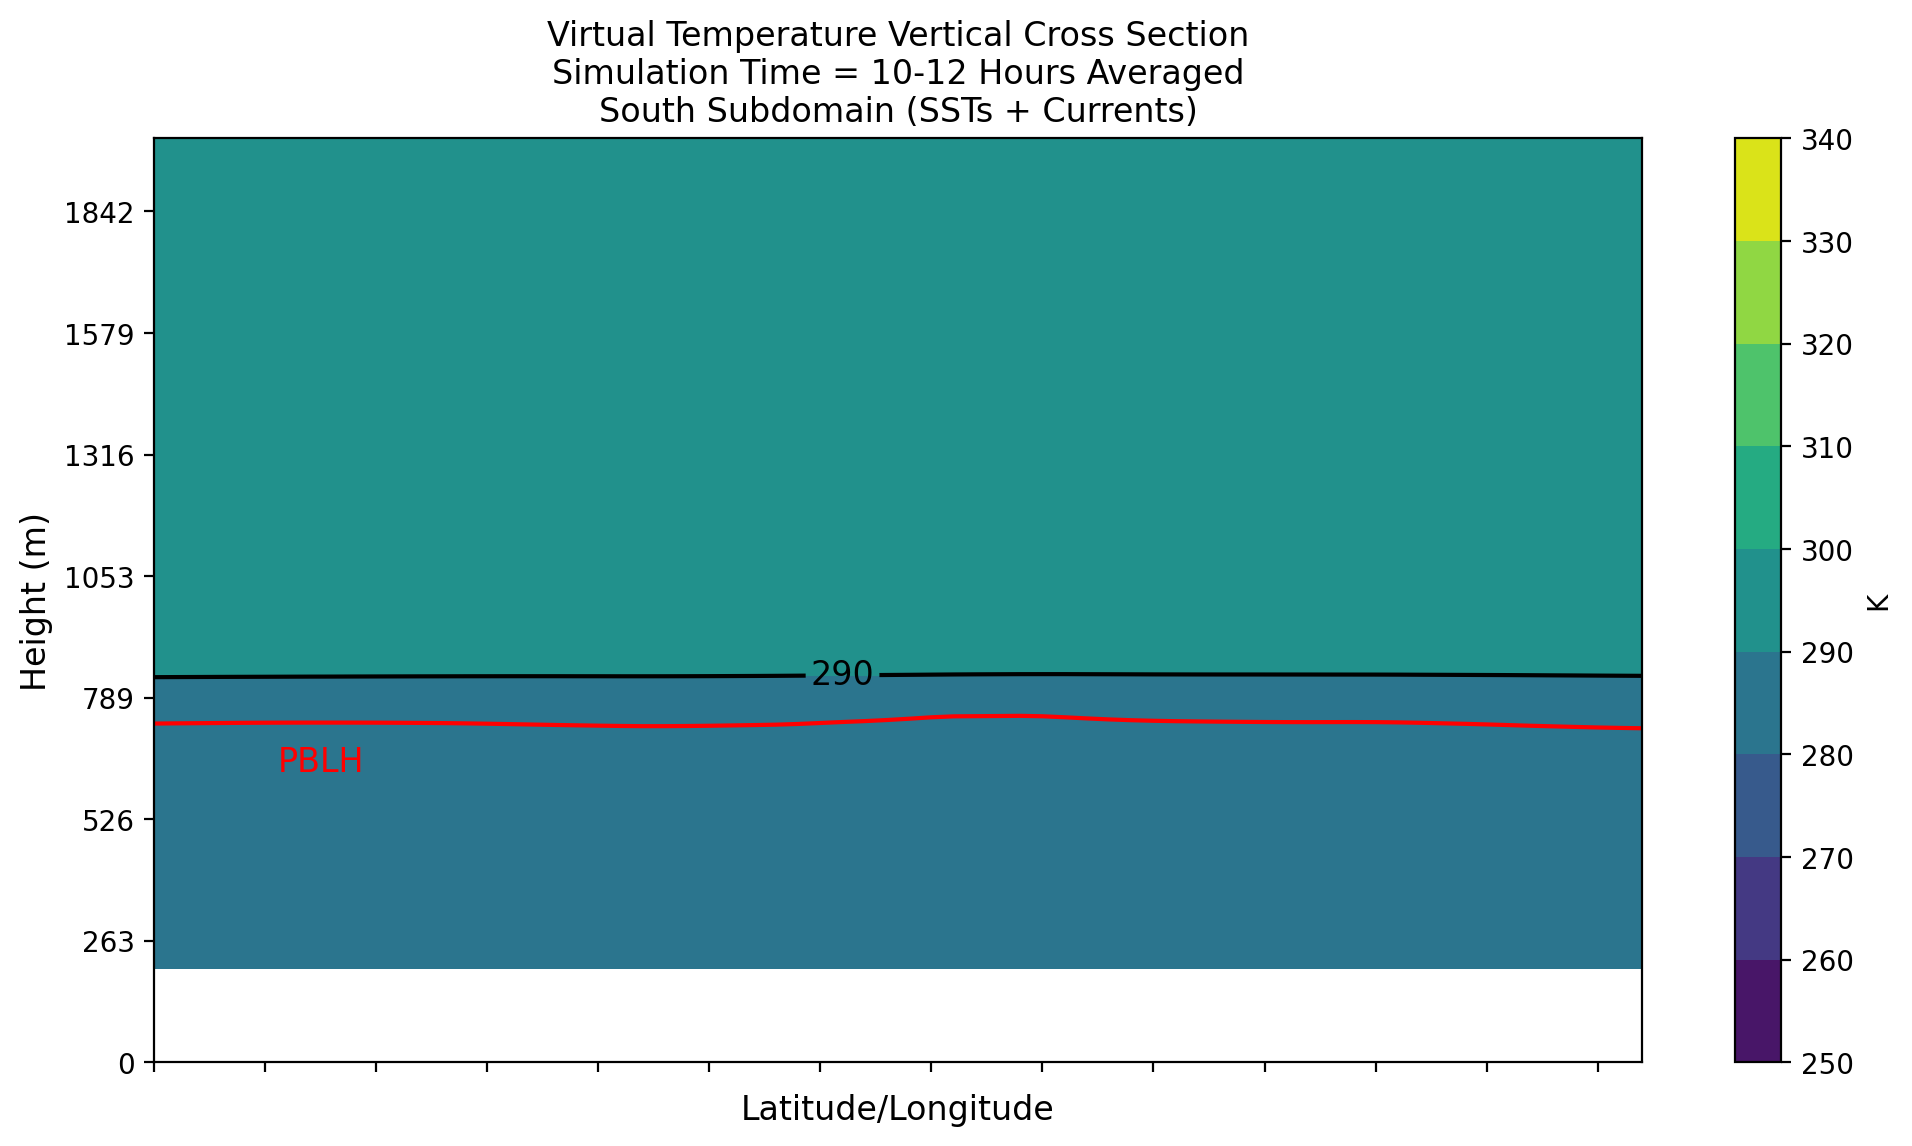

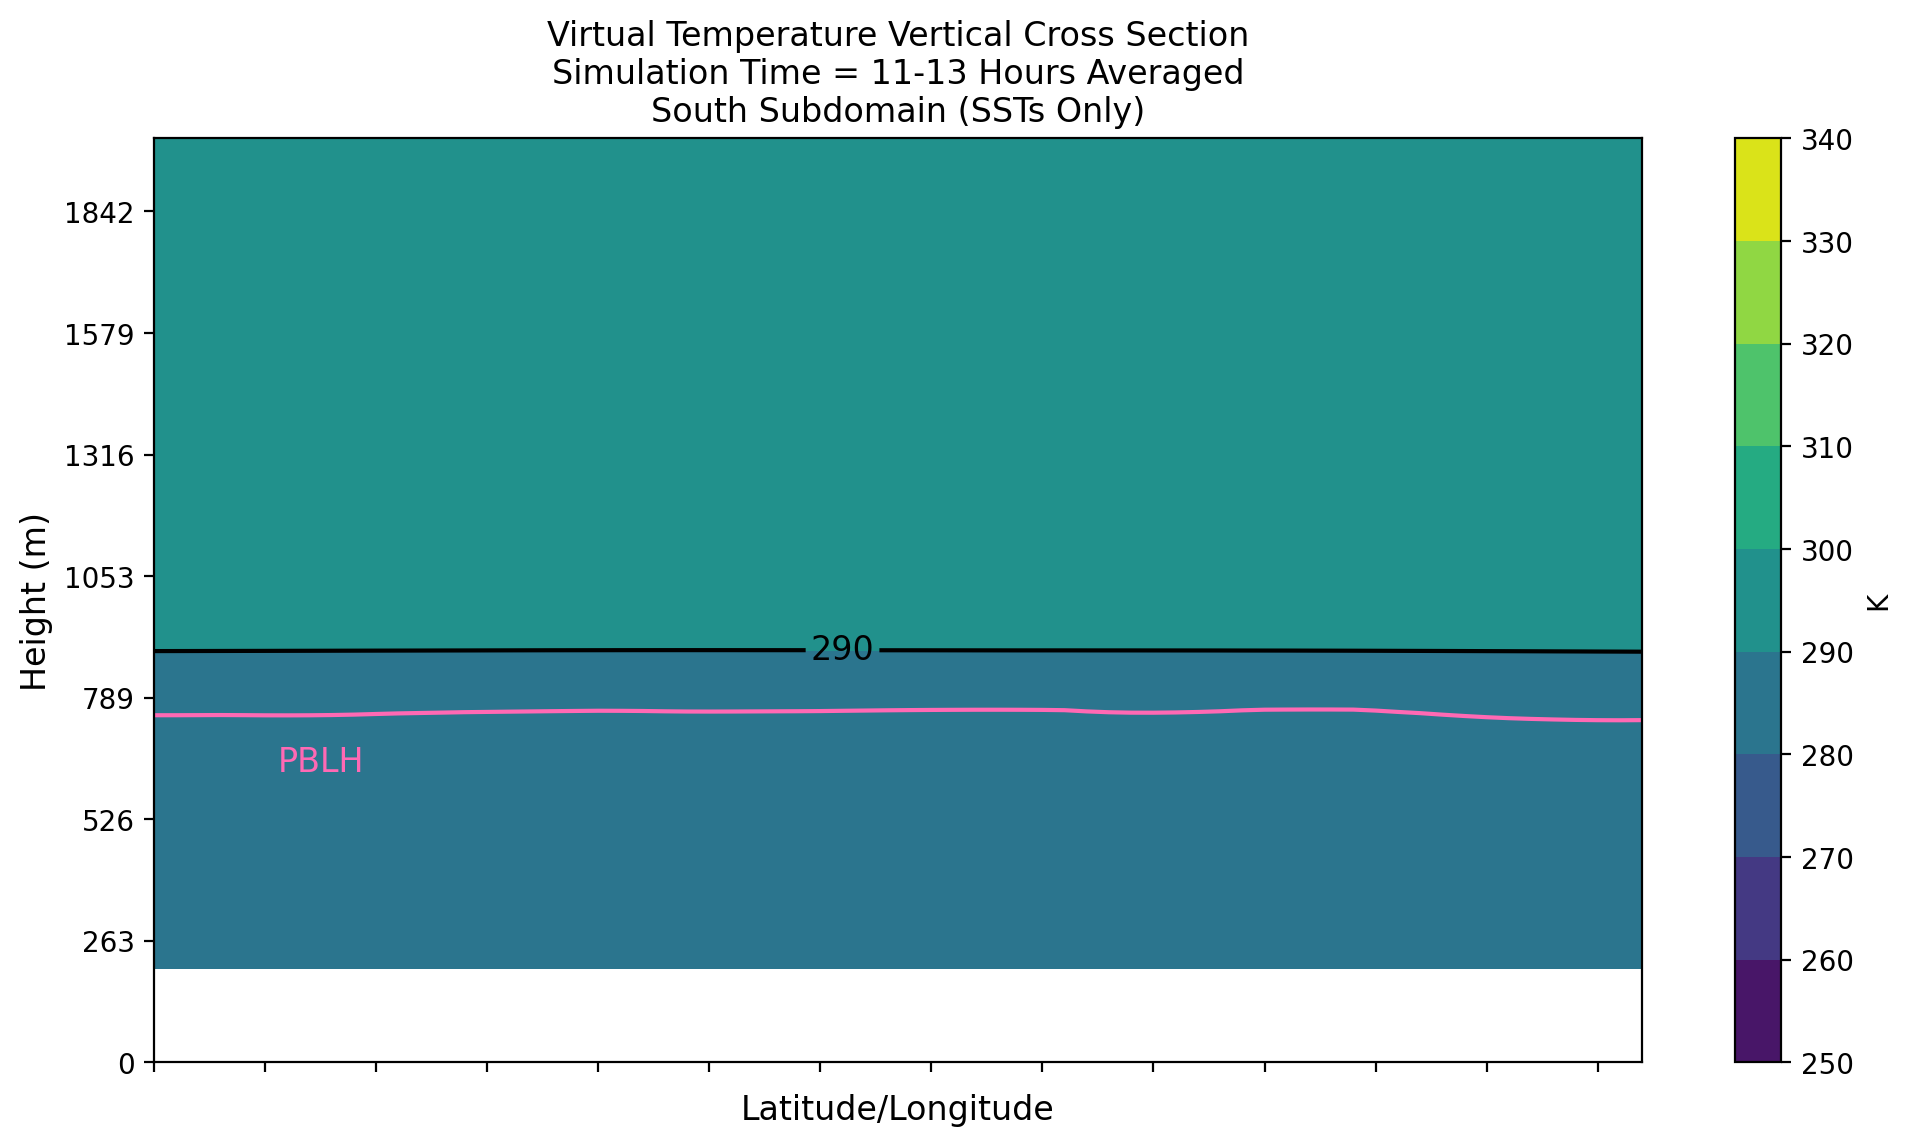

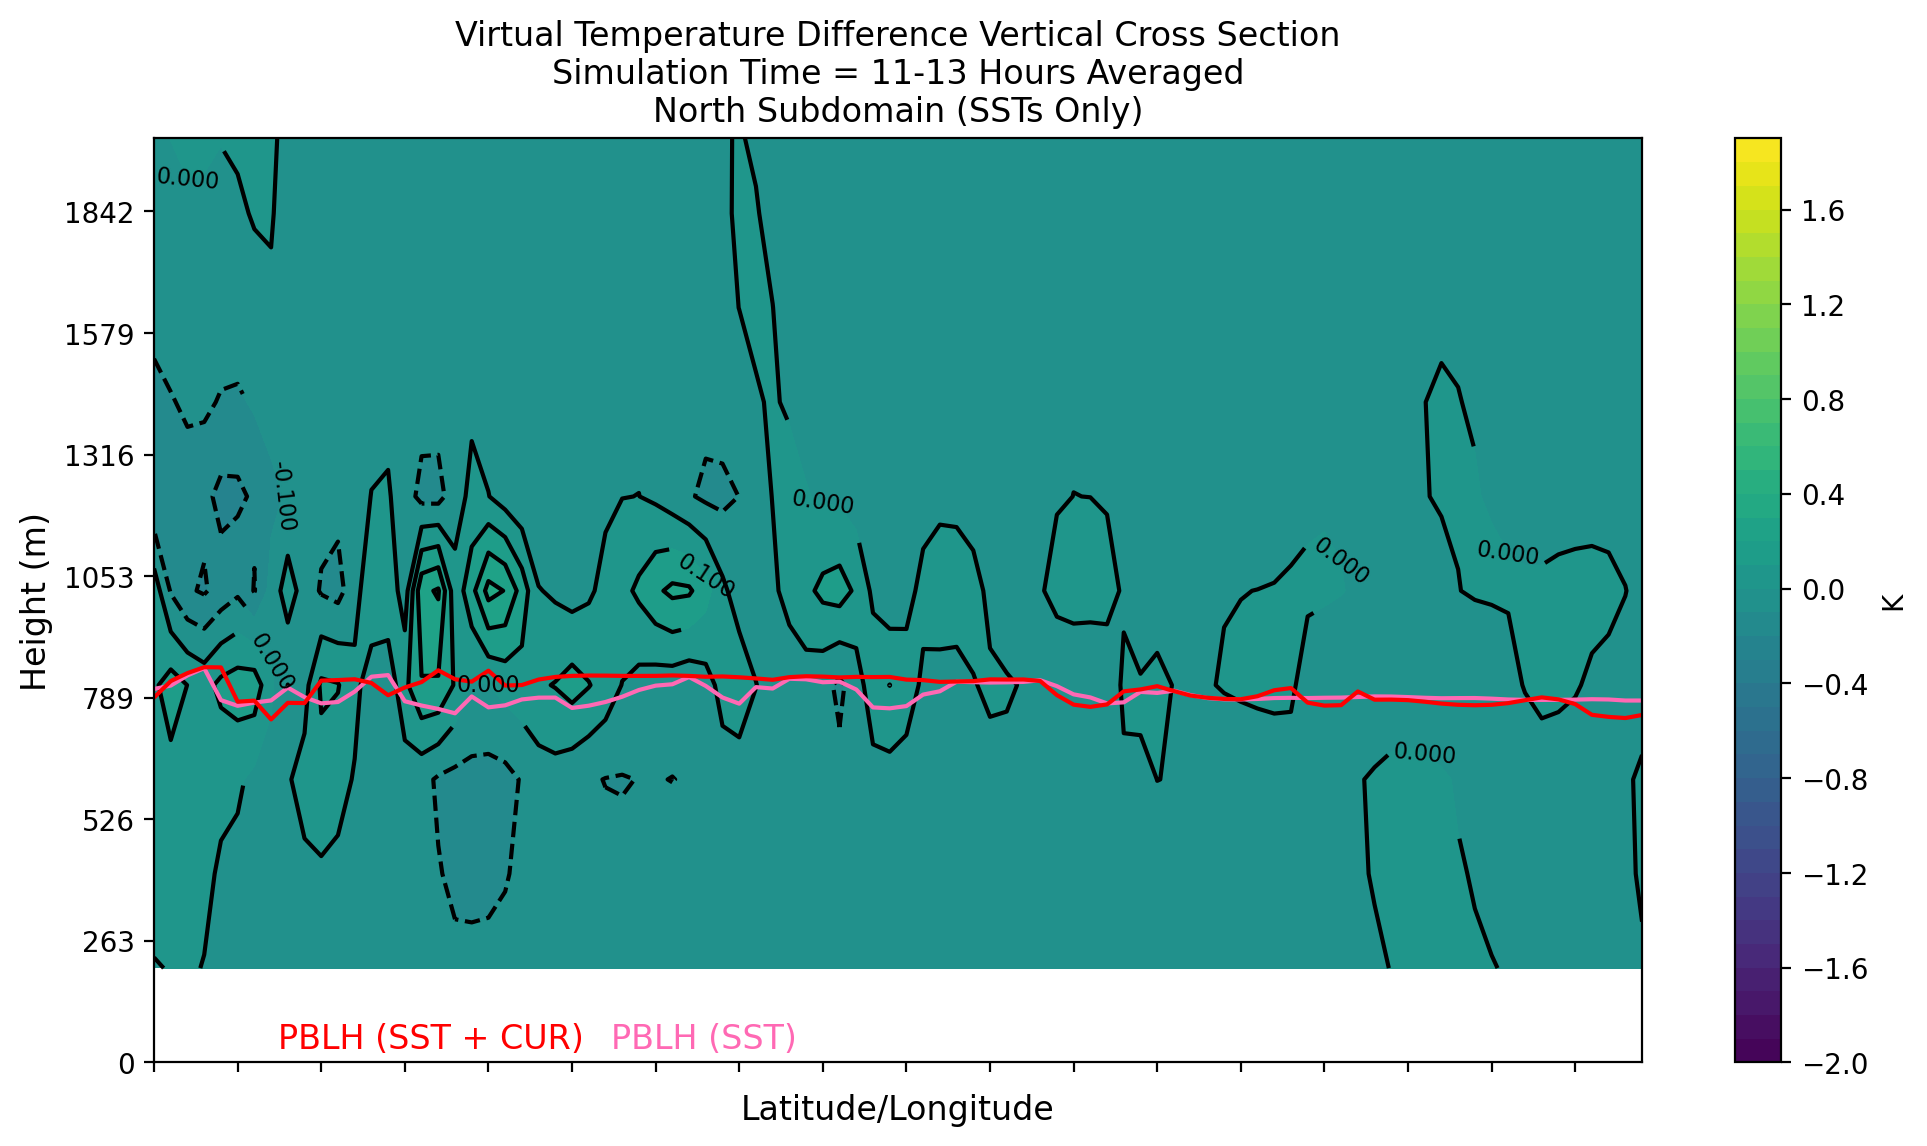

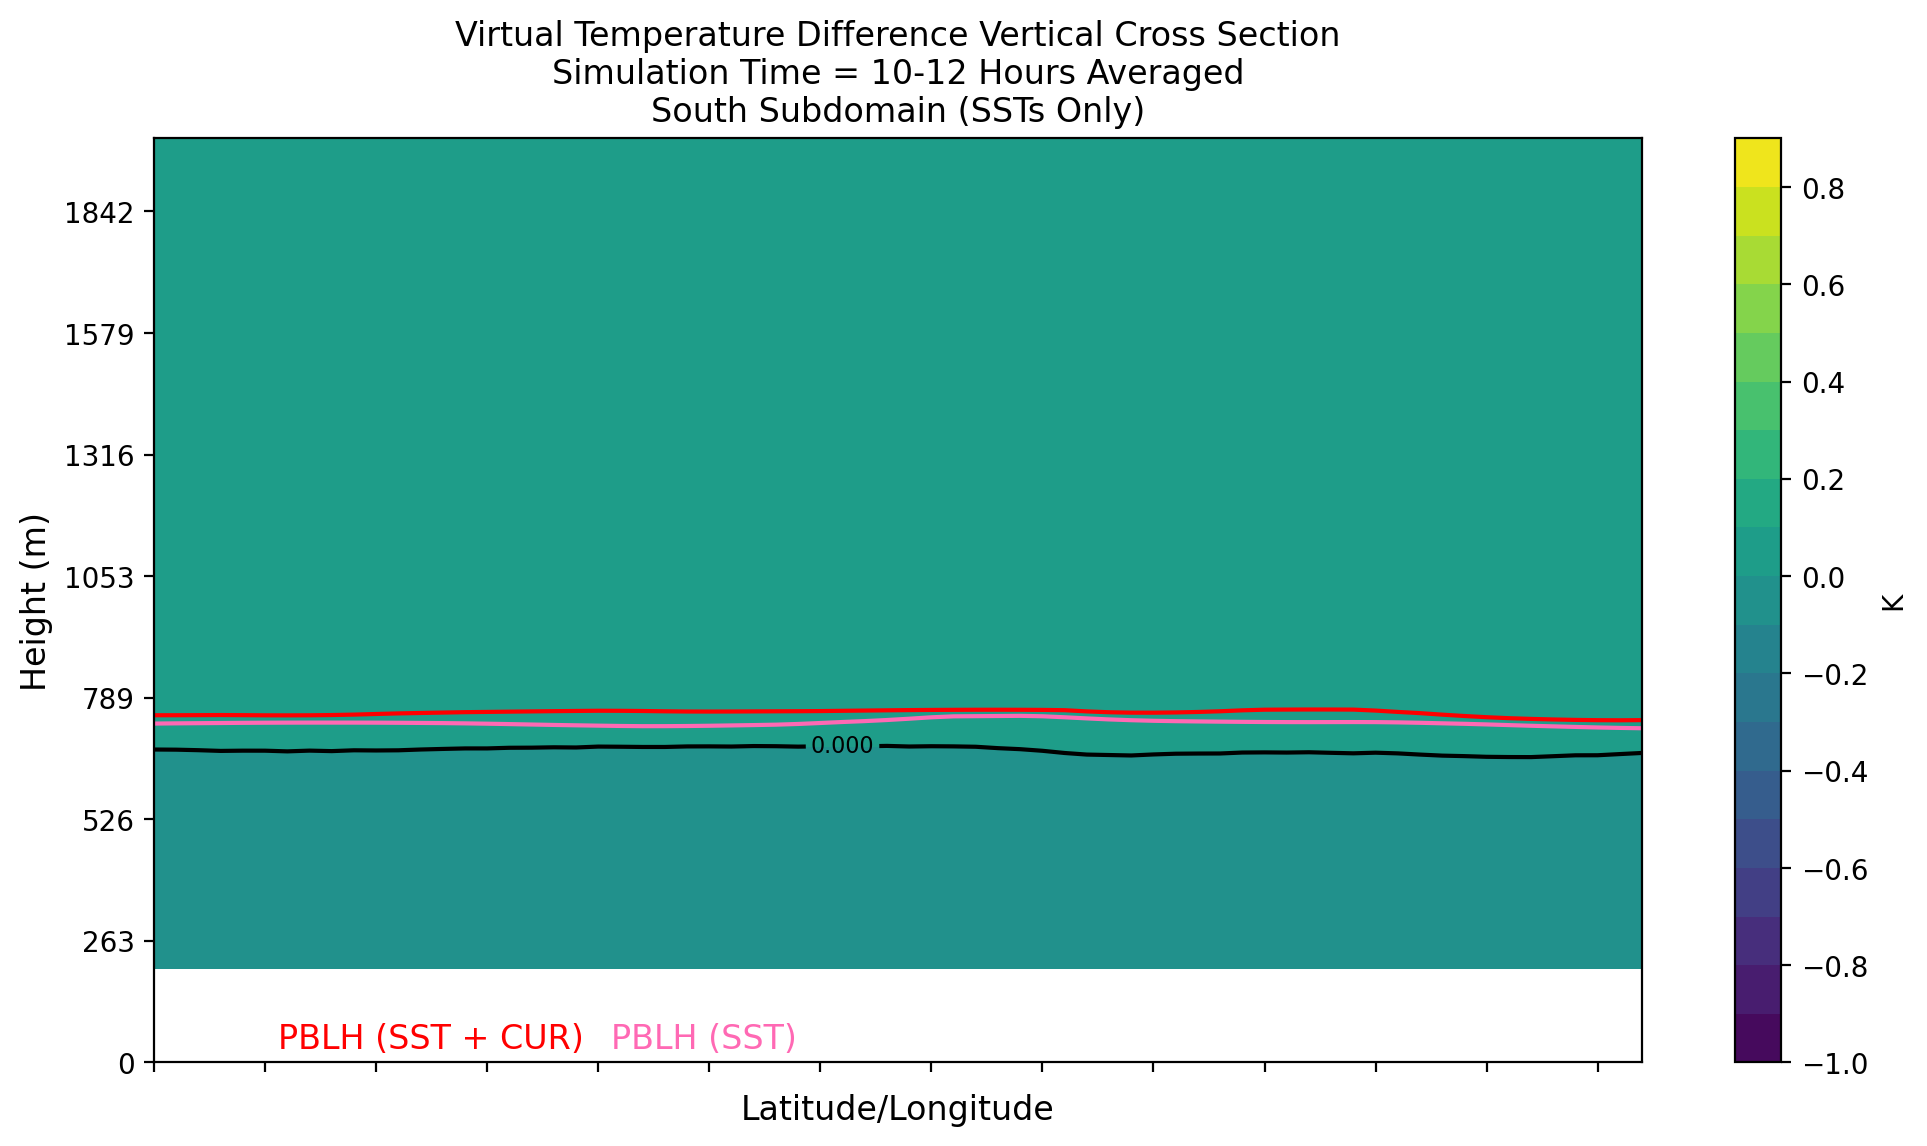

In [50]:
#CUR NORTH-----------------------------------
z = z_cur_north
theta = cur_tv_north
pblh_line = N_pblh_line_cur

start_point = CoordPair(lat=28.5, lon=-89.1)
end_point = CoordPair(lat=27.7, lon=-89.1)

theta_cross = vertcross(theta, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

fig = plt.figure(figsize=(12,6), dpi=200.)
ax = plt.axes()
coord_pairs = to_np(theta_cross.coords["xy_loc"])
x = np.arange(coord_pairs.shape[0])
y = pblh_line

theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(250.,350.,10.),cmap=get_cmap("viridis"))
plt.colorbar(theta_contours, ax=ax,  label = 'K')
theta_contours_line = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(250.,350.,10.), colors = 'black')

plt.clabel(theta_contours_line, inline=1, fontsize=12, fmt="%i", colors = 'black')
plt.plot(x, y, color = 'red' )
ax.annotate('PBLH',xy=(100, 135), xycoords='figure points', fontsize=12, color = 'red')

x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_yticks(np.linspace(0, 5000, 20))
ax.set_ylim(0, 2000) #900 max PBLH + 500m = 1400m + 200 m buffer = 1600m
ax.set_xticks(x_ticks[::5])
ax.set_xticklabels(x_labels[::5], rotation=45, fontsize=10)
ax.set_xlabel("Latitude/Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)
plt.title("Virtual Temperature Vertical Cross Section\nSimulation Time = 11-13 Hours Averaged\nNorth Subdomain (SSTs + Currents)")
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Tv/'
plt.savefig(save_results_to + 'north_tvCross_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#SST NORTH----------------------------------------------------------------------------------------
z = z_sst_north
theta = sst_tv_north
pblh_line = N_pblh_line_sst

start_point = CoordPair(lat=28.5, lon=-89.1)
end_point = CoordPair(lat=27.7, lon=-89.1)

theta_cross = vertcross(theta, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

fig = plt.figure(figsize=(12,6), dpi=200.)
ax = plt.axes()

coord_pairs = to_np(theta_cross.coords["xy_loc"])

x = np.arange(coord_pairs.shape[0])
y = pblh_line

theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(250.,350.,10.),cmap=get_cmap("viridis"))
plt.colorbar(theta_contours, ax=ax,  label = 'K')
theta_contours_line = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(250.,350.,10.), colors = 'black')


plt.clabel(theta_contours_line, inline=1, fontsize=12, fmt="%i", colors = 'black')
plt.plot(x, y, color = 'hotpink' )
ax.annotate('PBLH',xy=(100, 135), xycoords='figure points', fontsize=12, color = 'hotpink')

x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_yticks(np.linspace(0, 5000, 20))
ax.set_ylim(0, 2000) #900 max PBLH + 500m = 1400m + 200 m buffer = 1600m
ax.set_xticks(x_ticks[::5])
ax.set_xticklabels(x_labels[::5], rotation=45, fontsize=10)
ax.set_xlabel("Latitude/Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)
plt.title("Virtual Temperature Vertical Cross Section\nSimulation Time = 11-13 Hours Averaged\nNorth Subdomain (SSTs Only)")
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Tv/'
plt.savefig(save_results_to + 'north_tvCross_sst.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#CUR SOUTH----------------------------------------------------------------------------------------
z = z_cur_south
theta = cur_tv_south
pblh_line = S_pblh_line_cur

start_point = CoordPair(lat=26.6, lon=-89.9)
end_point = CoordPair(lat=26.0, lon=-89.9)

theta_cross = vertcross(theta, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

fig = plt.figure(figsize=(12,6), dpi=200.)
ax = plt.axes()

coord_pairs = to_np(theta_cross.coords["xy_loc"])

x = np.arange(coord_pairs.shape[0])
y = pblh_line

theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(250.,350.,10.),cmap=get_cmap("viridis"))
plt.colorbar(theta_contours, ax=ax,  label = 'K')
theta_contours_line = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(250.,350.,10.), colors = 'black')


plt.clabel(theta_contours_line, inline=1, fontsize=12, fmt="%i", colors = 'black')
plt.plot(x, y, color = 'red' )
ax.annotate('PBLH',xy=(100, 135), xycoords='figure points', fontsize=12, color = 'red')

x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_yticks(np.linspace(0, 5000, 20))
ax.set_ylim(0, 2000) #900 max PBLH + 500m = 1400m + 200 m buffer = 1600m
ax.set_xticks(x_ticks[::5])
ax.set_xticklabels(x_labels[::5], rotation=45, fontsize=10)
ax.set_xlabel("Latitude/Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)
plt.title("Virtual Temperature Vertical Cross Section\nSimulation Time = 10-12 Hours Averaged\nSouth Subdomain (SSTs + Currents)")
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Tv/'
plt.savefig(save_results_to + 'south_tvCross_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()


#SST SOUTH------------------------------------------------------------------------------------
z = z_sst_south
theta = sst_tv_south
pblh_line = S_pblh_line_sst

start_point = CoordPair(lat=26.6, lon=-89.1)
end_point = CoordPair(lat=26.0, lon=-89.1)

theta_cross = vertcross(theta, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

fig = plt.figure(figsize=(12,6), dpi=200.)
ax = plt.axes()

coord_pairs = to_np(theta_cross.coords["xy_loc"])

x = np.arange(coord_pairs.shape[0])
y = pblh_line

theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(250.,350.,10.),cmap=get_cmap("viridis"))
plt.colorbar(theta_contours, ax=ax,  label = 'K')
theta_contours_line = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(250.,350.,10.), colors = 'black')


plt.clabel(theta_contours_line, inline=1, fontsize=12, fmt="%i", colors = 'black')
plt.plot(x, y, color = 'hotpink' )
ax.annotate('PBLH',xy=(100, 135), xycoords='figure points', fontsize=12, color = 'hotpink')

x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_yticks(np.linspace(0, 5000, 20))
ax.set_ylim(0, 2000) #900 max PBLH + 500m = 1400m + 200 m buffer = 1600m
ax.set_xticks(x_ticks[::5])
ax.set_xticklabels(x_labels[::5], rotation=45, fontsize=10)
ax.set_xlabel("Latitude/Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)
plt.title("Virtual Temperature Vertical Cross Section\nSimulation Time = 11-13 Hours Averaged\nSouth Subdomain (SSTs Only)")
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Tv/'
plt.savefig(save_results_to + 'south_tvCross_sst.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#N DIFF----------------------------------------------------------------------------------
z = z_sst_north
theta = N_diff
pblh_line1 = N_pblh_line_cur
pblh_line2 = N_pblh_line_sst

start_point = CoordPair(lat=28.5, lon=-89.1)
end_point = CoordPair(lat=27.7, lon=-89.1)

theta_cross = vertcross(theta, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

fig = plt.figure(figsize=(12,6), dpi=200.)
ax = plt.axes()

coord_pairs = to_np(theta_cross.coords["xy_loc"])

x1 = np.arange(coord_pairs.shape[0])
y1 = pblh_line1
x2 = np.arange(coord_pairs.shape[0])
y2 = pblh_line2

theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-2.0,2.0,0.1),cmap=get_cmap("viridis"))
plt.colorbar(theta_contours, ax=ax,  label = 'K')
theta_contours_line = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-2.0,2.0,0.1), colors = 'black')

plt.clabel(theta_contours_line,  fontsize=8, fmt='%1.3f', colors = 'black')
plt.plot(x1, y1, color = 'hotpink' )
ax.annotate('PBLH (SST)',xy=(220, 35), xycoords='figure points', fontsize=12, color = 'hotpink')

plt.plot(x2, y2, color = 'red' )
ax.annotate('PBLH (SST + CUR)',xy=(100, 35), xycoords='figure points', fontsize=12, color = 'red')

x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_yticks(np.linspace(0, 5000, 20))
ax.set_ylim(0, 2000) #900 max PBLH + 500m = 1400m + 200 m buffer = 1600m
ax.set_xticks(x_ticks[::5])
ax.set_xticklabels(x_labels[::5], rotation=45, fontsize=10)
ax.set_xlabel("Latitude/Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)
plt.title("Virtual Temperature Difference Vertical Cross Section\nSimulation Time = 11-13 Hours Averaged\nNorth Subdomain (SSTs Only)")
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Tv/'
plt.savefig(save_results_to + 'north_tvCross_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#S DIFF---------------------------------------------------------------------
z = z_sst_south
theta = S_diff
pblh_line1 = S_pblh_line_cur
pblh_line2 = S_pblh_line_sst

start_point = CoordPair(lat=26.6, lon=-89.9)
end_point = CoordPair(lat=26.0, lon=-89.9)

theta_cross = vertcross(theta, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

fig = plt.figure(figsize=(12,6), dpi=200.)
ax = plt.axes()

coord_pairs = to_np(theta_cross.coords["xy_loc"])

x1 = np.arange(coord_pairs.shape[0])
y1 = pblh_line1
x2 = np.arange(coord_pairs.shape[0])
y2 = pblh_line2

theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-1.0,1.0,0.1),cmap=get_cmap("viridis"))
plt.colorbar(theta_contours, ax=ax,  label = 'K')
theta_contours_line = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-2.0,2.0,0.1), colors = 'black')

plt.clabel(theta_contours_line, fontsize=8, fmt='%1.3f', colors = 'black')
plt.plot(x1, y1, color = 'hotpink' )
ax.annotate('PBLH (SST)',xy=(220, 35), xycoords='figure points', fontsize=12, color = 'hotpink')

plt.plot(x2, y2, color = 'red' )
ax.annotate('PBLH (SST + CUR)',xy=(100, 35), xycoords='figure points', fontsize=12, color = 'red')

x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_yticks(np.linspace(0, 5000, 20))
ax.set_ylim(0, 2000) #900 max PBLH + 500m = 1400m + 200 m buffer = 1600m
ax.set_xticks(x_ticks[::5])
ax.set_xticklabels(x_labels[::5], rotation=45, fontsize=10)
ax.set_xlabel("Latitude/Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)
plt.title("Virtual Temperature Difference Vertical Cross Section\nSimulation Time = 10-12 Hours Averaged\nSouth Subdomain (SSTs Only)")
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Tv/'
plt.savefig(save_results_to + 'south_tvCross_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()


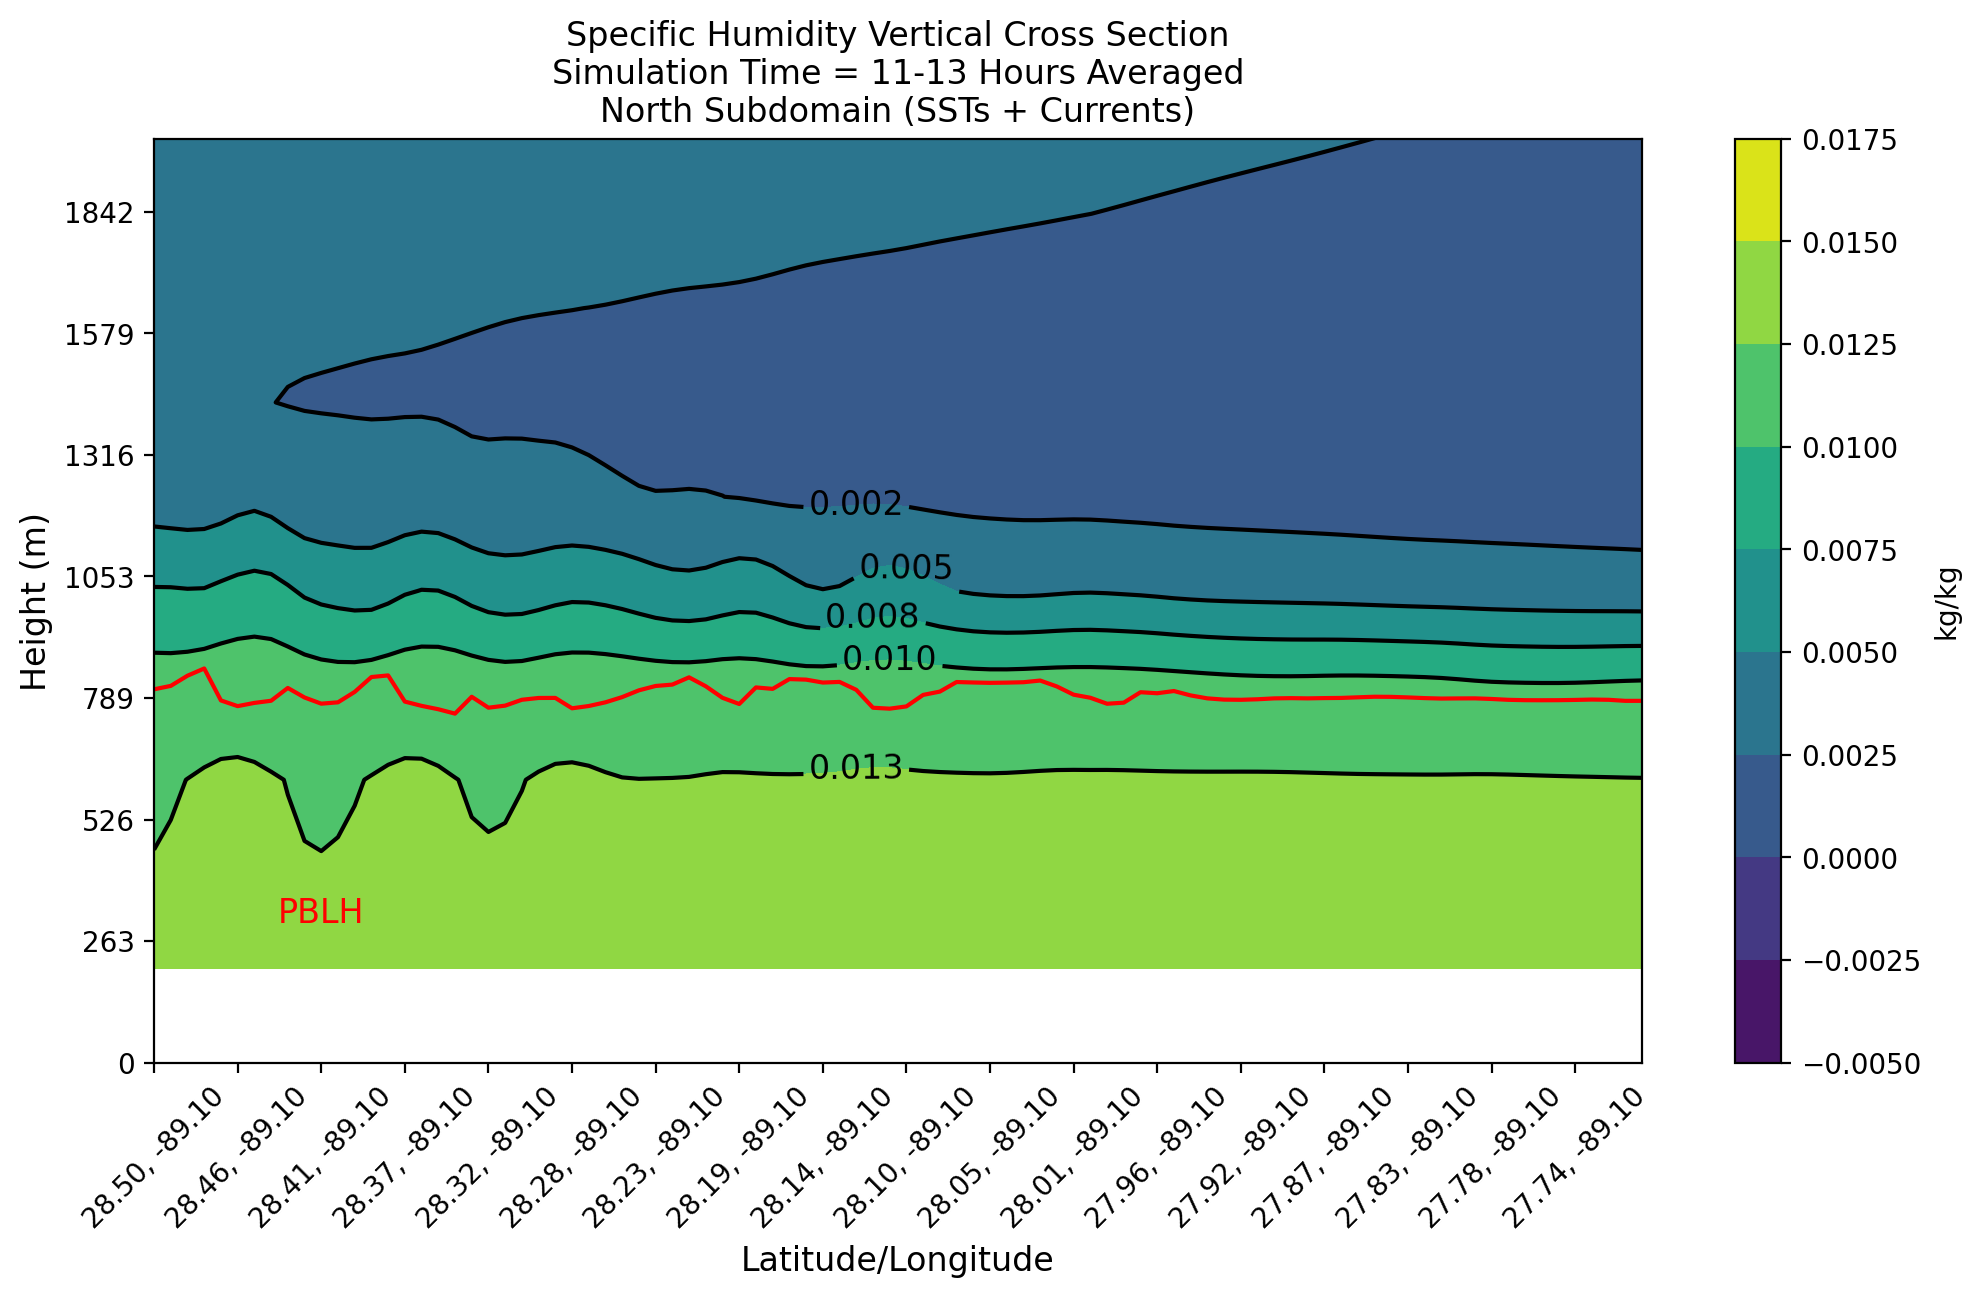

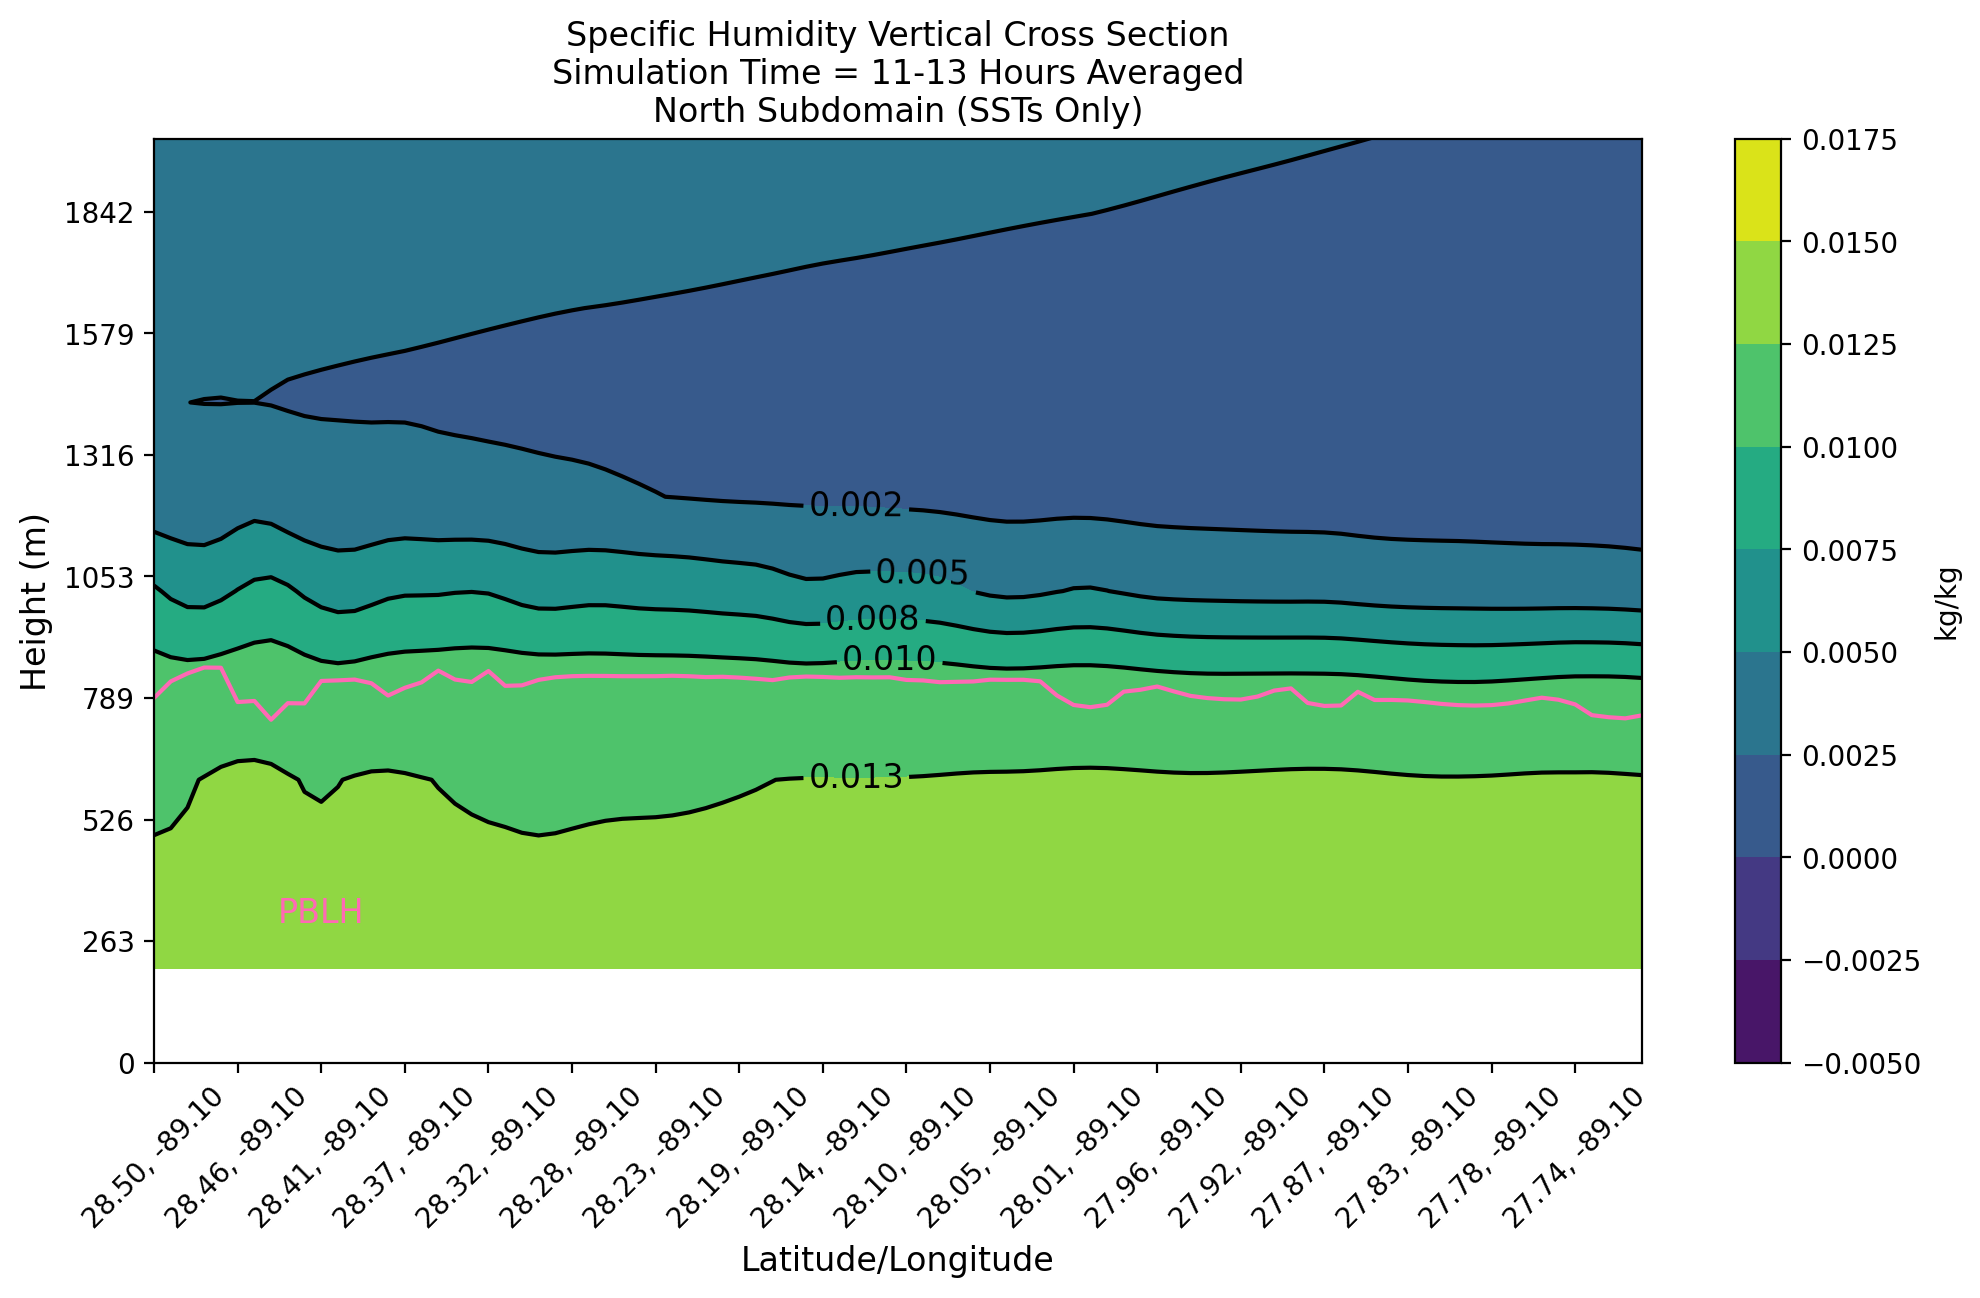

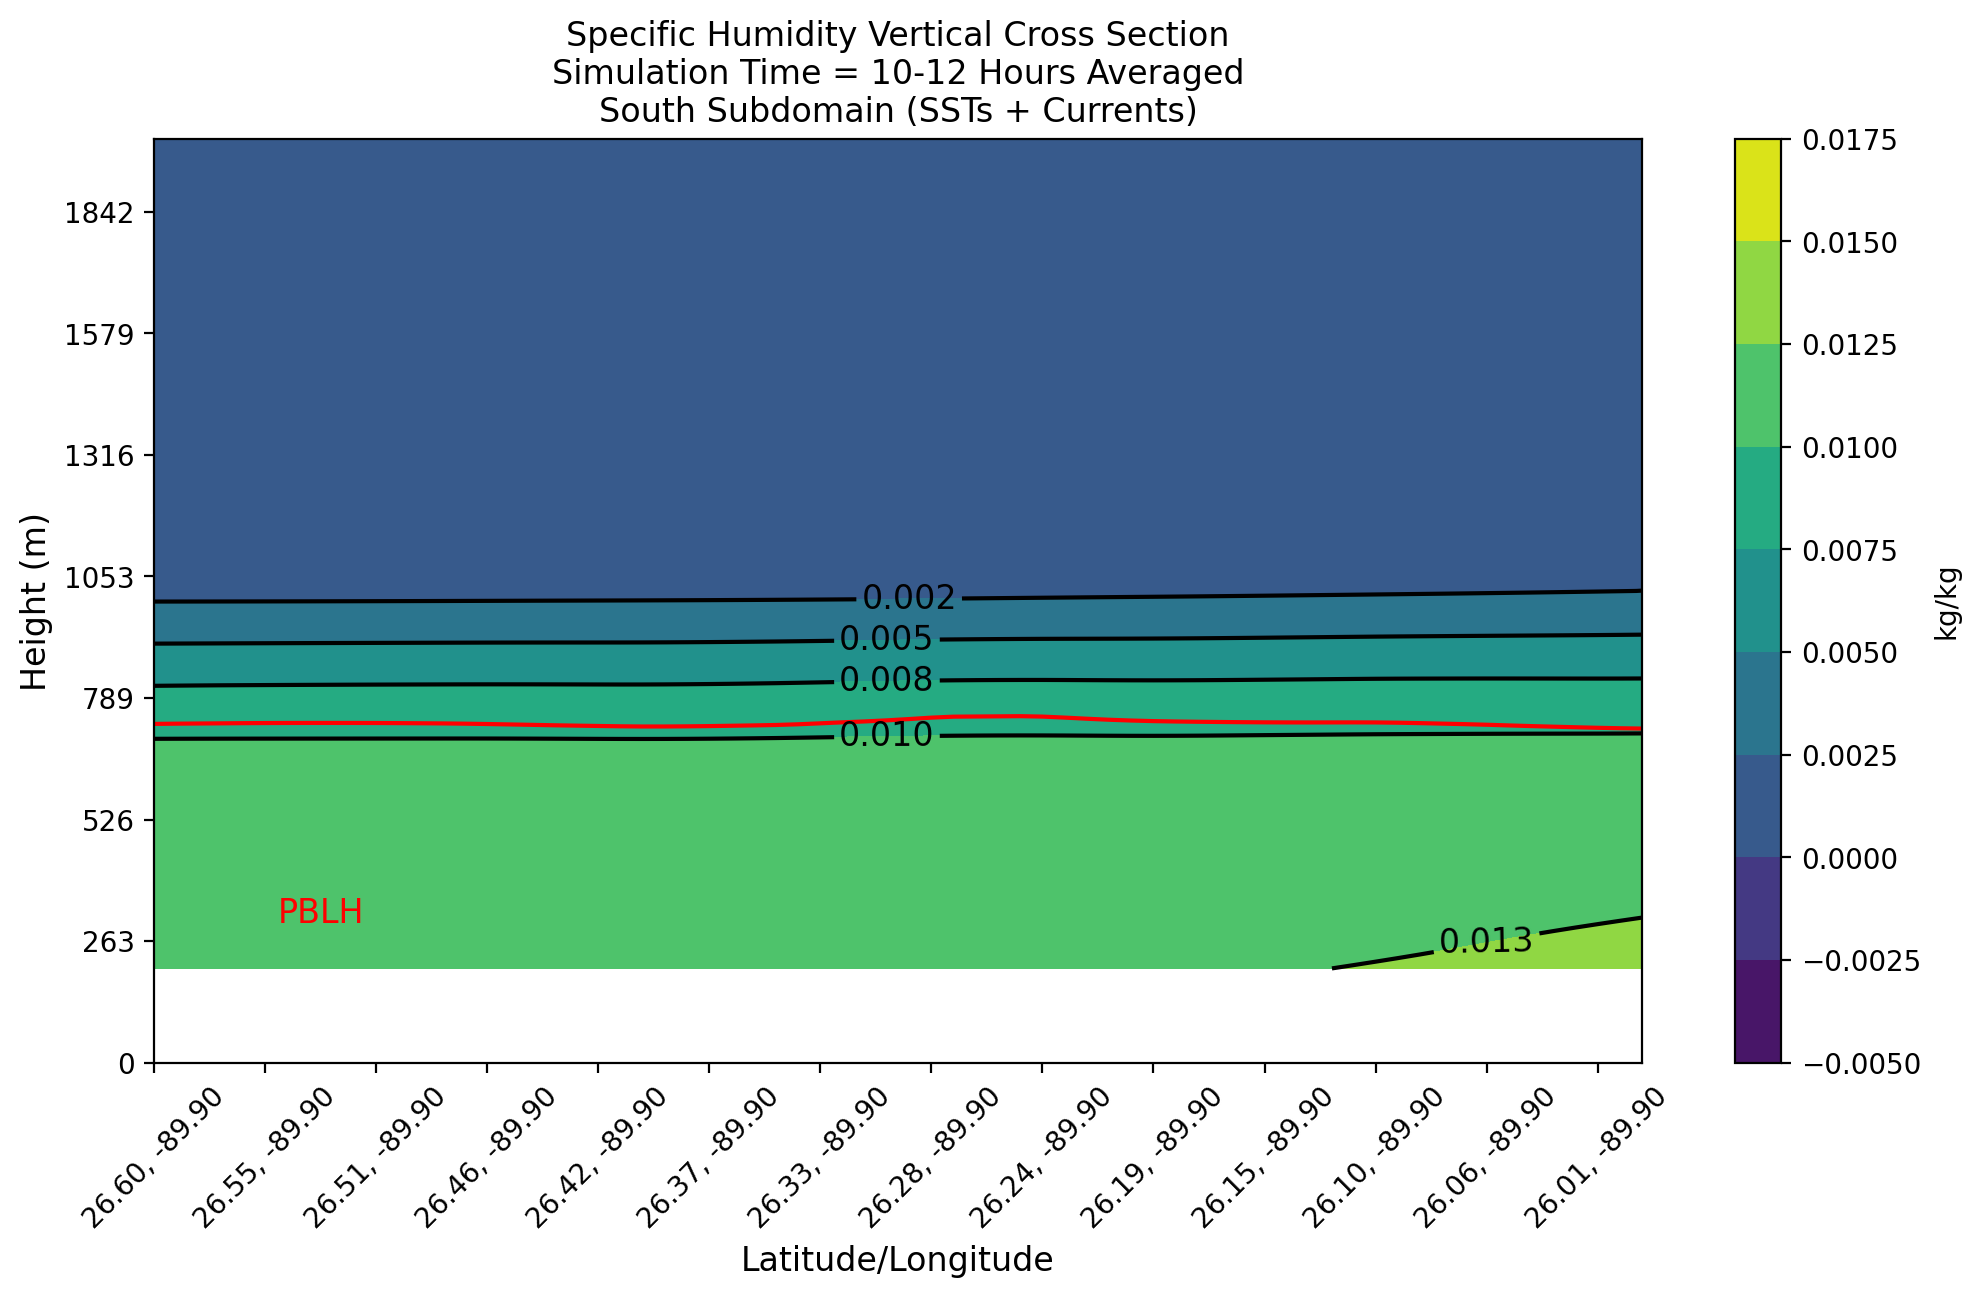

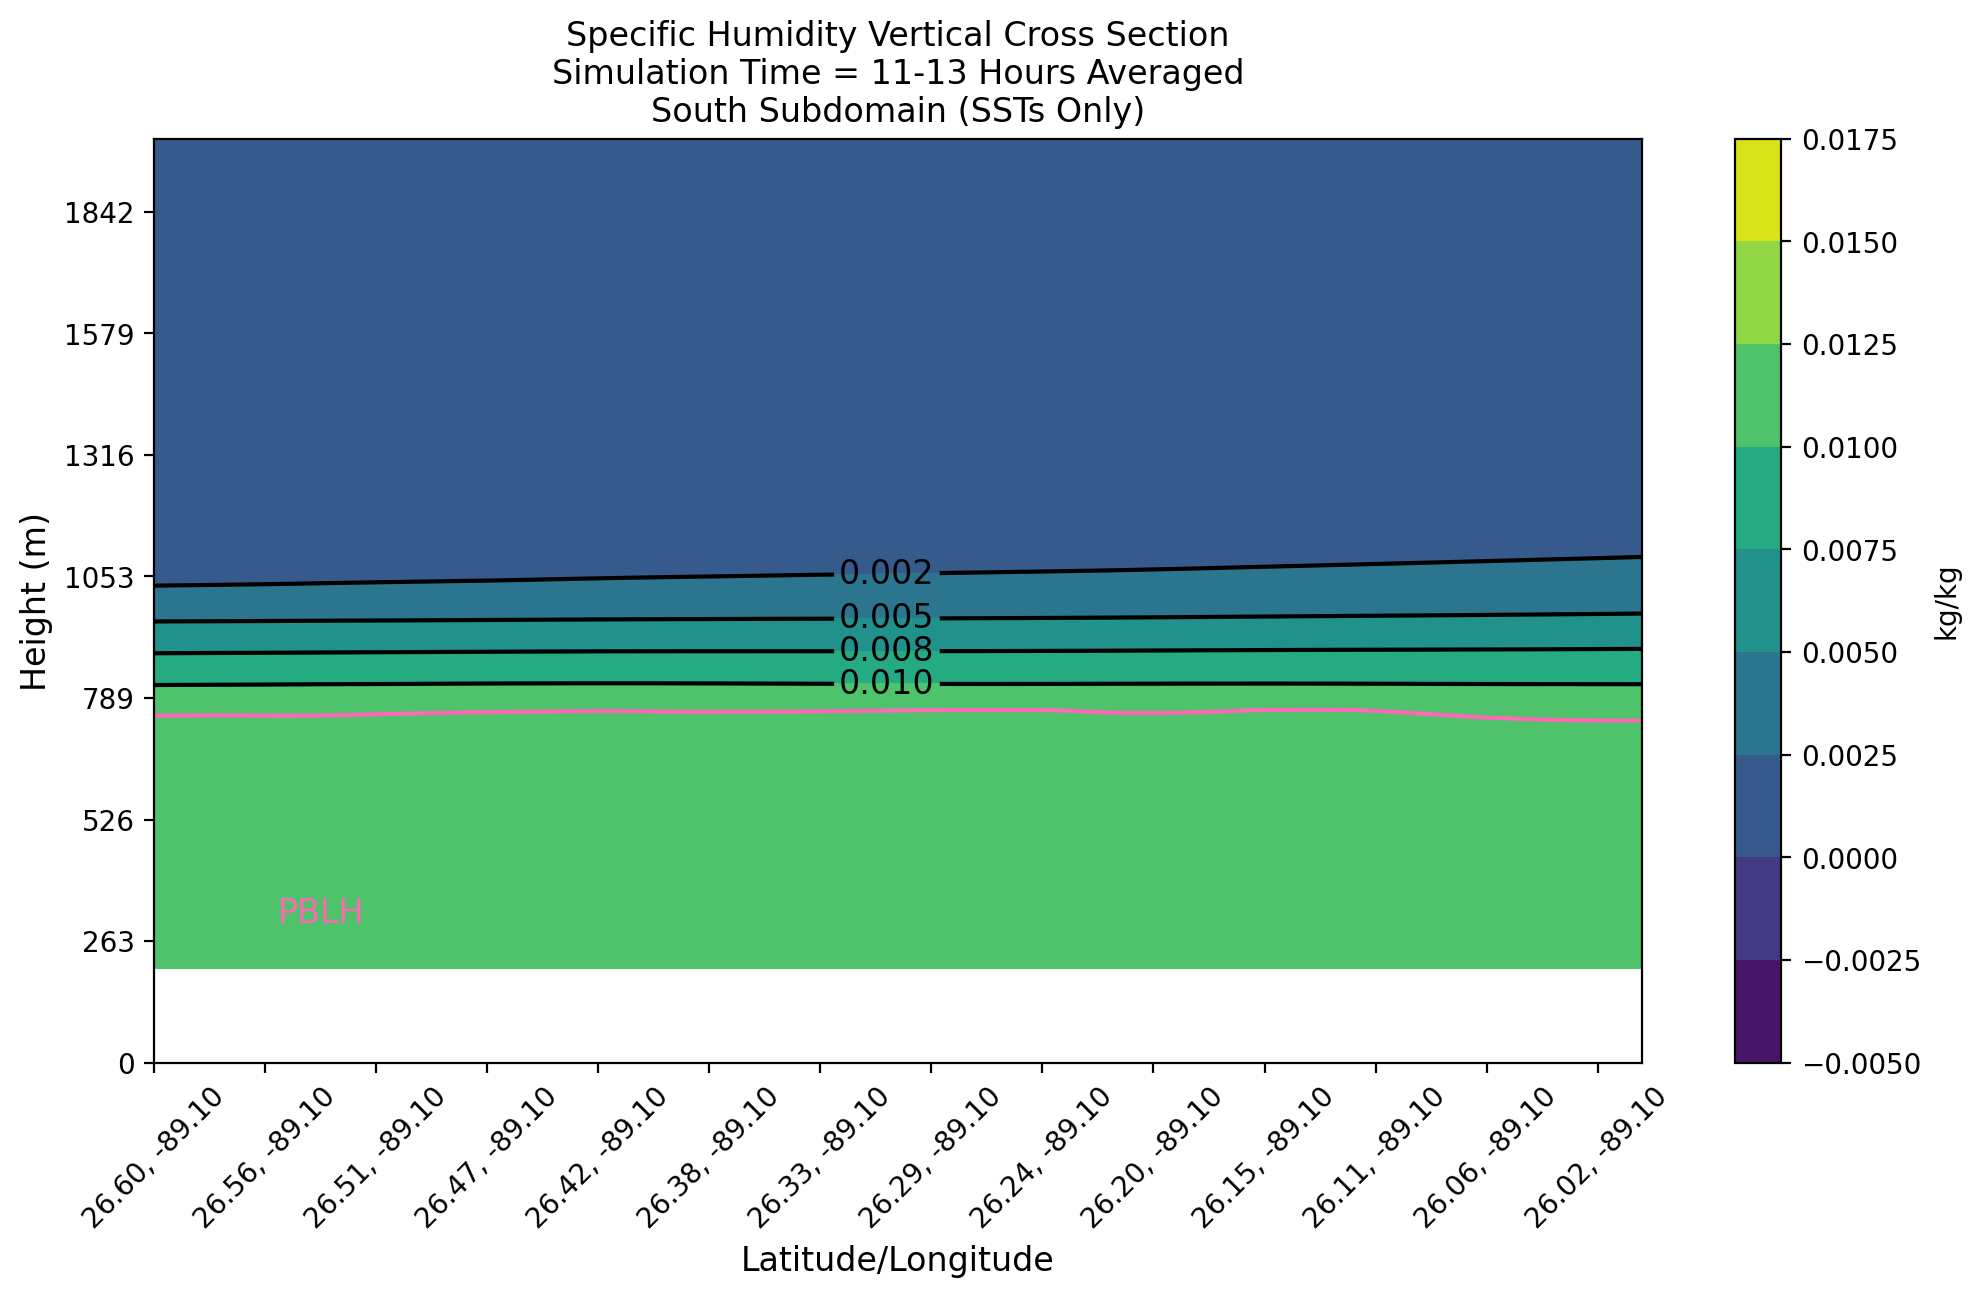

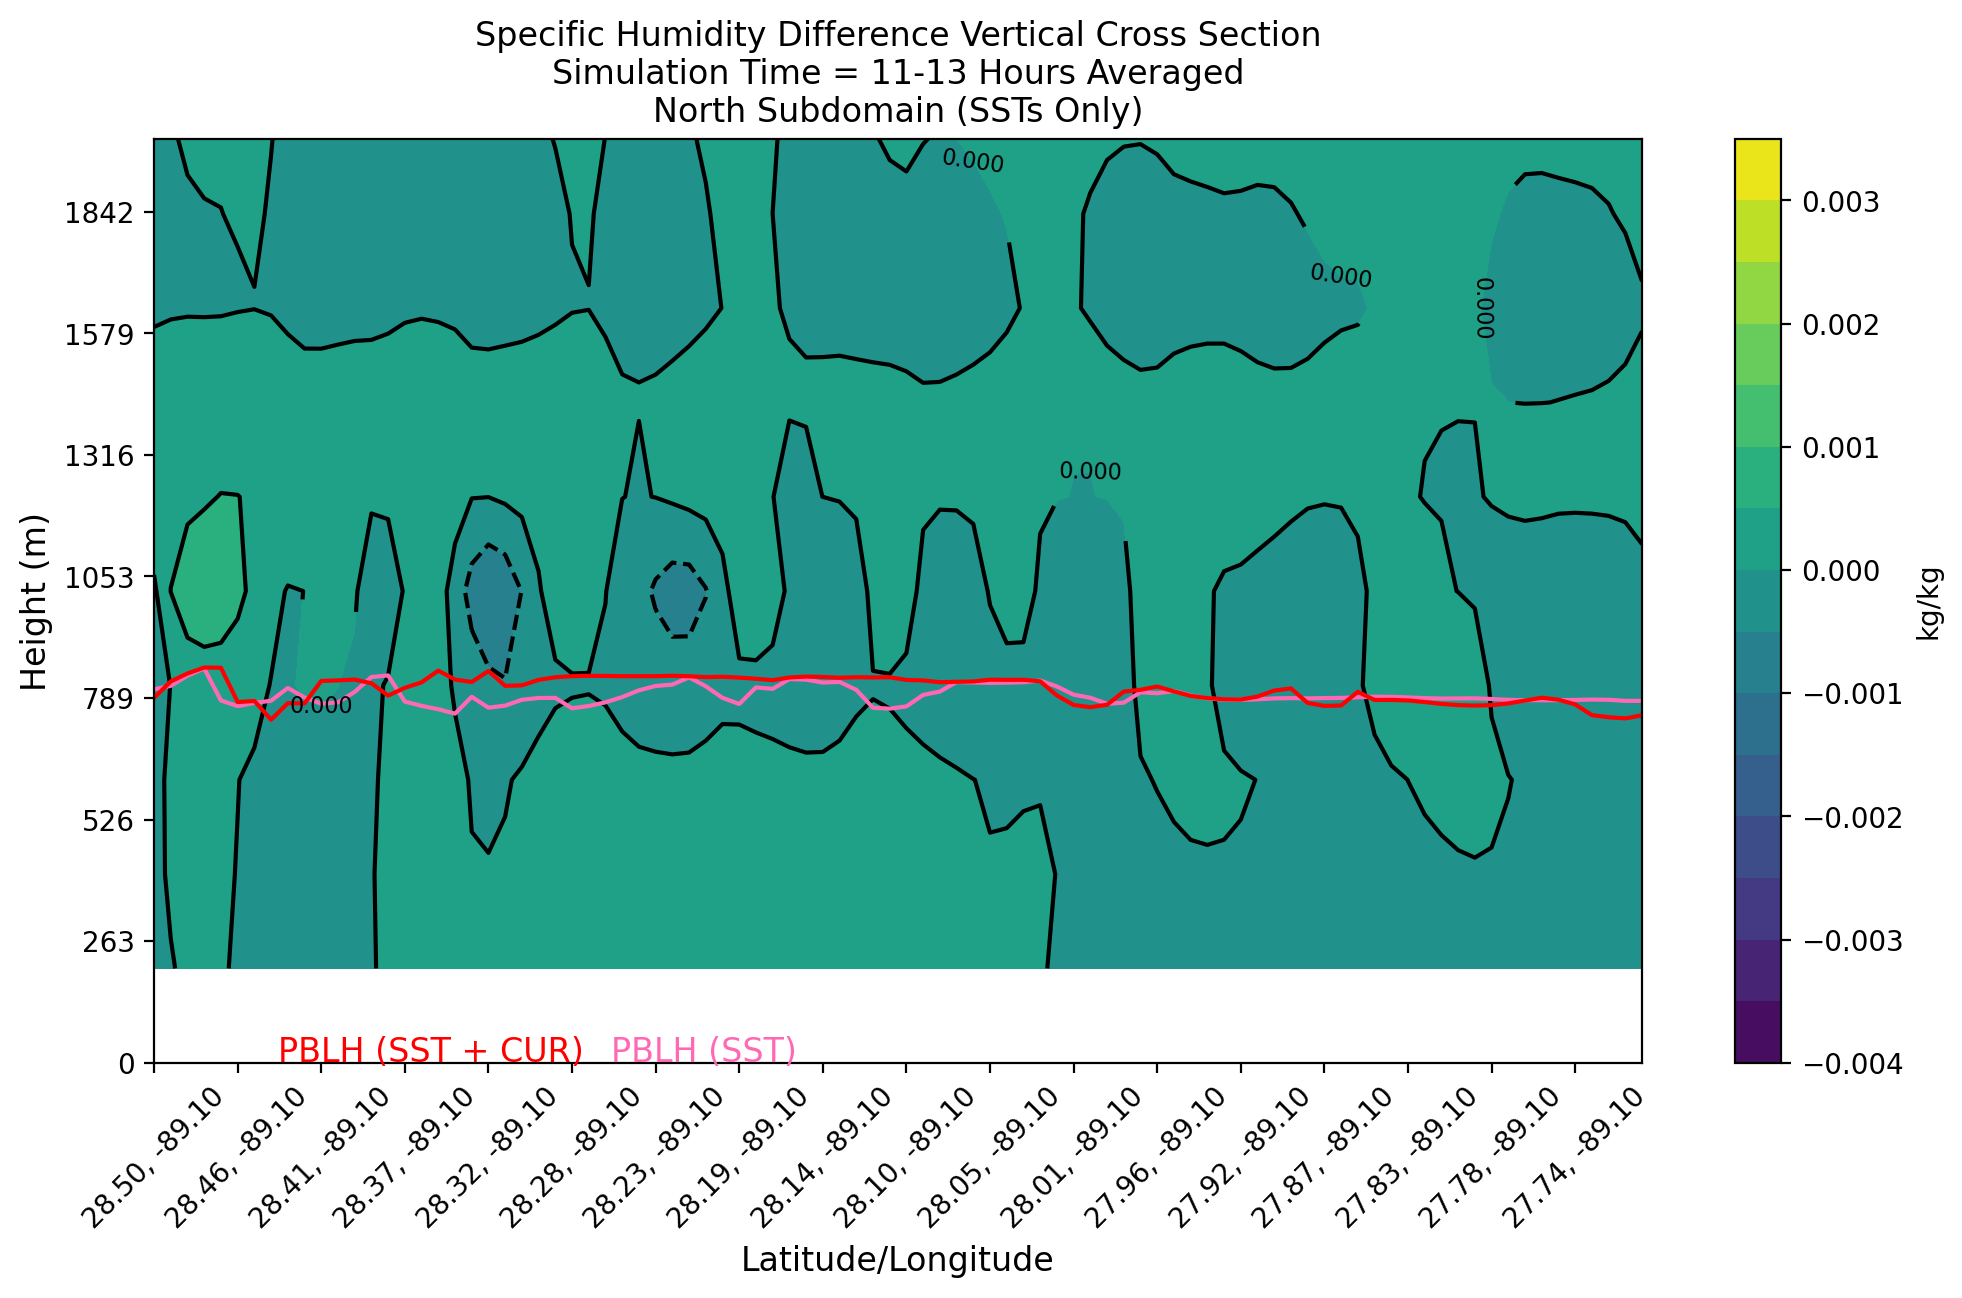

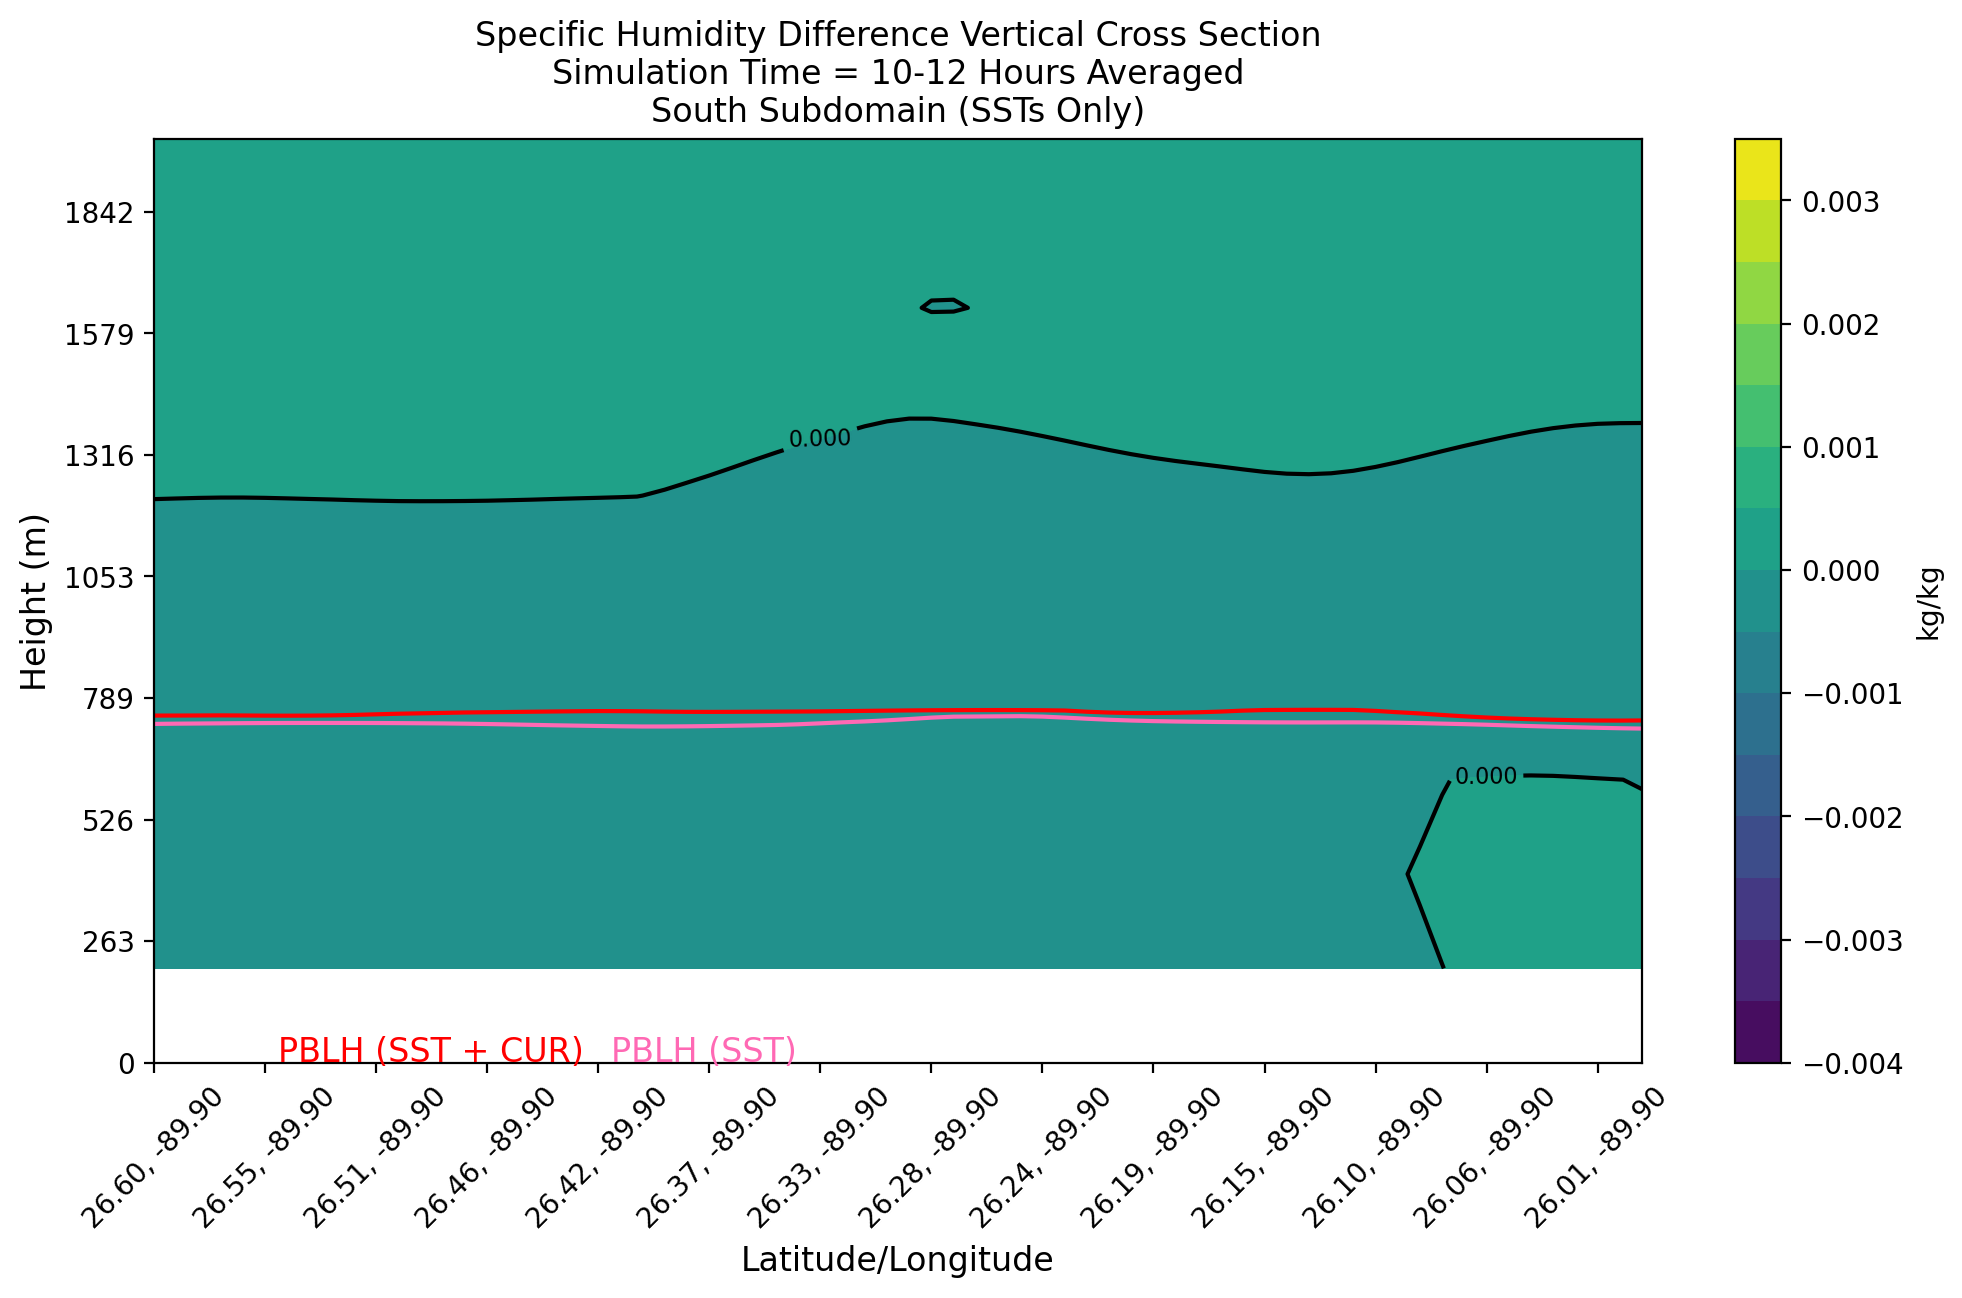

In [53]:
#Qv range: 
#0.01559238
#9.9082888e-07

#Diff Rangs
#0.00295248  to -0.00308028

#CUR NORTH-----------------------------------
z = z_cur_north
theta = cur_qv_north
pblh_line = N_pblh_line_cur

start_point = CoordPair(lat=28.5, lon=-89.1)
end_point = CoordPair(lat=27.7, lon=-89.1)

theta_cross = vertcross(theta, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

fig = plt.figure(figsize=(12,6), dpi=200.)
ax = plt.axes()
coord_pairs = to_np(theta_cross.coords["xy_loc"])
x = np.arange(coord_pairs.shape[0])
y = pblh_line

theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-0.005, 0.02, 0.0025),cmap=get_cmap("viridis"))
plt.colorbar(theta_contours, ax=ax,  label = 'kg/kg')
theta_contours_line = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-0.005, 0.02, 0.0025), colors = 'black')

plt.clabel(theta_contours_line, inline=1, fontsize=12, fmt='%1.3f', colors = 'black')
plt.plot(x, y, color = 'red' )
ax.annotate('PBLH',xy=(100, 135), xycoords='figure points', fontsize=12, color = 'red')

x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_yticks(np.linspace(0, 5000, 20))
ax.set_ylim(0, 2000) #900 max PBLH + 500m = 1400m + 200 m buffer = 1600m
ax.set_xticks(x_ticks[::5])
ax.set_xticklabels(x_labels[::5], rotation=45, fontsize=10)
ax.set_xlabel("Latitude/Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)
plt.title("Specific Humidity Vertical Cross Section\nSimulation Time = 11-13 Hours Averaged\nNorth Subdomain (SSTs + Currents)")
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Qv/'
plt.savefig(save_results_to + 'north_qvCross_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#SST NORTH----------------------------------------------------------------------------------------
z = z_sst_north
theta = sst_qv_north
pblh_line = N_pblh_line_sst

start_point = CoordPair(lat=28.5, lon=-89.1)
end_point = CoordPair(lat=27.7, lon=-89.1)

theta_cross = vertcross(theta, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

fig = plt.figure(figsize=(12,6), dpi=200.)
ax = plt.axes()

coord_pairs = to_np(theta_cross.coords["xy_loc"])

x = np.arange(coord_pairs.shape[0])
y = pblh_line

theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-0.005, 0.02, 0.0025),cmap=get_cmap("viridis"))
plt.colorbar(theta_contours, ax=ax,  label = 'kg/kg')
theta_contours_line = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-0.005, 0.02, 0.0025), colors = 'black')


plt.clabel(theta_contours_line, inline=1, fontsize=12, fmt='%1.3f', colors = 'black')
plt.plot(x, y, color = 'hotpink' )
ax.annotate('PBLH',xy=(100, 135), xycoords='figure points', fontsize=12, color = 'hotpink')

x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_yticks(np.linspace(0, 5000, 20))
ax.set_ylim(0, 2000) #900 max PBLH + 500m = 1400m + 200 m buffer = 1600m
ax.set_xticks(x_ticks[::5])
ax.set_xticklabels(x_labels[::5], rotation=45, fontsize=10)
ax.set_xlabel("Latitude/Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)
plt.title("Specific Humidity Vertical Cross Section\nSimulation Time = 11-13 Hours Averaged\nNorth Subdomain (SSTs Only)")
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Qv/'
plt.savefig(save_results_to + 'north_qvCross_sst.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#CUR SOUTH----------------------------------------------------------------------------------------
z = z_cur_south
theta = cur_qv_south
pblh_line = S_pblh_line_cur

start_point = CoordPair(lat=26.6, lon=-89.9)
end_point = CoordPair(lat=26.0, lon=-89.9)

theta_cross = vertcross(theta, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

fig = plt.figure(figsize=(12,6), dpi=200.)
ax = plt.axes()

coord_pairs = to_np(theta_cross.coords["xy_loc"])

x = np.arange(coord_pairs.shape[0])
y = pblh_line

theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-0.005, 0.02, 0.0025),cmap=get_cmap("viridis"))
plt.colorbar(theta_contours, ax=ax,  label = 'kg/kg')
theta_contours_line = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-0.005, 0.02, 0.0025), colors = 'black')


plt.clabel(theta_contours_line, inline=1, fontsize=12, fmt='%1.3f', colors = 'black')
plt.plot(x, y, color = 'red' )
ax.annotate('PBLH',xy=(100, 135), xycoords='figure points', fontsize=12, color = 'red')

x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_yticks(np.linspace(0, 5000, 20))
ax.set_ylim(0, 2000) #900 max PBLH + 500m = 1400m + 200 m buffer = 1600m
ax.set_xticks(x_ticks[::5])
ax.set_xticklabels(x_labels[::5], rotation=45, fontsize=10)
ax.set_xlabel("Latitude/Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)
plt.title("Specific Humidity Vertical Cross Section\nSimulation Time = 10-12 Hours Averaged\nSouth Subdomain (SSTs + Currents)")
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Qv/'
plt.savefig(save_results_to + 'south_qvCross_cur.png', bbox_inches = 'tight',dpi = 150)
plt.show()


#SST SOUTH------------------------------------------------------------------------------------
z = z_sst_south
theta = sst_qv_south
pblh_line = S_pblh_line_sst

start_point = CoordPair(lat=26.6, lon=-89.1)
end_point = CoordPair(lat=26.0, lon=-89.1)

theta_cross = vertcross(theta, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

fig = plt.figure(figsize=(12,6), dpi=200.)
ax = plt.axes()

coord_pairs = to_np(theta_cross.coords["xy_loc"])

x = np.arange(coord_pairs.shape[0])
y = pblh_line

theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-0.005, 0.02, 0.0025),cmap=get_cmap("viridis"))
plt.colorbar(theta_contours, ax=ax,  label = 'kg/kg')
theta_contours_line = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-0.005, 0.02, 0.0025), colors = 'black')


plt.clabel(theta_contours_line, inline=1, fontsize=12, fmt='%1.3f', colors = 'black')
plt.plot(x, y, color = 'hotpink' )
ax.annotate('PBLH',xy=(100, 135), xycoords='figure points', fontsize=12, color = 'hotpink')

x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_yticks(np.linspace(0, 5000, 20))
ax.set_ylim(0, 2000) #900 max PBLH + 500m = 1400m + 200 m buffer = 1600m
ax.set_xticks(x_ticks[::5])
ax.set_xticklabels(x_labels[::5], rotation=45, fontsize=10)
ax.set_xlabel("Latitude/Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)
plt.title("Specific Humidity Vertical Cross Section\nSimulation Time = 11-13 Hours Averaged\nSouth Subdomain (SSTs Only)")
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Qv/'
plt.savefig(save_results_to + 'south_qvCross_sst.png', bbox_inches = 'tight',dpi = 150)
plt.show

#N DIFF----------------------------------------------------------------------------------
z = z_sst_north
theta = N_qv_diff
pblh_line1 = N_pblh_line_cur
pblh_line2 = N_pblh_line_sst

start_point = CoordPair(lat=28.5, lon=-89.1)
end_point = CoordPair(lat=27.7, lon=-89.1)

theta_cross = vertcross(theta, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

fig = plt.figure(figsize=(12,6), dpi=200.)
ax = plt.axes()

coord_pairs = to_np(theta_cross.coords["xy_loc"])

x1 = np.arange(coord_pairs.shape[0])
y1 = pblh_line1
x2 = np.arange(coord_pairs.shape[0])
y2 = pblh_line2

theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-0.004,0.004,0.0005),cmap=get_cmap("viridis"))
plt.colorbar(theta_contours, ax=ax,  label = 'kg/kg')
theta_contours_line = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-0.004,0.004,0.0005), colors = 'black')

plt.clabel(theta_contours_line,  fontsize=8, fmt='%1.3f', colors = 'black')
plt.plot(x1, y1, color = 'hotpink' )
ax.annotate('PBLH (SST)',xy=(220, 85), xycoords='figure points', fontsize=12, color = 'hotpink')

plt.plot(x2, y2, color = 'red' )
ax.annotate('PBLH (SST + CUR)',xy=(100, 85), xycoords='figure points', fontsize=12, color = 'red')

x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_yticks(np.linspace(0, 5000, 20))
ax.set_ylim(0, 2000) #900 max PBLH + 500m = 1400m + 200 m buffer = 1600m
ax.set_xticks(x_ticks[::5])
ax.set_xticklabels(x_labels[::5], rotation=45, fontsize=10)
ax.set_xlabel("Latitude/Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)
plt.title("Specific Humidity Difference Vertical Cross Section\nSimulation Time = 11-13 Hours Averaged\nNorth Subdomain (SSTs Only)")
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Qv/'
plt.savefig(save_results_to + 'north_qvCross_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()

#S DIFF---------------------------------------------------------------------
z = z_sst_south
theta = S_qv_diff
pblh_line1 = S_pblh_line_cur
pblh_line2 = S_pblh_line_sst

start_point = CoordPair(lat=26.6, lon=-89.9)
end_point = CoordPair(lat=26.0, lon=-89.9)

theta_cross = vertcross(theta, z, wrfin=cur_wrfout12, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

fig = plt.figure(figsize=(12,6), dpi=200.)
ax = plt.axes()

coord_pairs = to_np(theta_cross.coords["xy_loc"])

x1 = np.arange(coord_pairs.shape[0])
y1 = pblh_line1
x2 = np.arange(coord_pairs.shape[0])
y2 = pblh_line2

theta_contours = ax.contourf(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-0.004,0.004,0.0005),cmap=get_cmap("viridis"))
plt.colorbar(theta_contours, ax=ax,  label = 'kg/kg')
theta_contours_line = ax.contour(np.arange(coord_pairs.shape[0]),to_np(theta_cross["vertical"]),
                           to_np(theta_cross),np.arange(-0.004,0.004,0.0005), colors = 'black')

plt.clabel(theta_contours_line, fontsize=8, fmt='%1.3f', colors = 'black')
plt.plot(x1, y1, color = 'hotpink' )
ax.annotate('PBLH (SST)',xy=(220, 85), xycoords='figure points', fontsize=12, color = 'hotpink')

plt.plot(x2, y2, color = 'red' )
ax.annotate('PBLH (SST + CUR)',xy=(100, 85), xycoords='figure points', fontsize=12, color = 'red')

x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_yticks(np.linspace(0, 5000, 20))
ax.set_ylim(0, 2000) #900 max PBLH + 500m = 1400m + 200 m buffer = 1600m
ax.set_xticks(x_ticks[::5])
ax.set_xticklabels(x_labels[::5], rotation=45, fontsize=10)
ax.set_xlabel("Latitude/Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)
plt.title("Specific Humidity Difference Vertical Cross Section\nSimulation Time = 10-12 Hours Averaged\nSouth Subdomain (SSTs Only)")
save_results_to = '/Users/Anna/Desktop/WRF/Thesis_Plots/Qv/'
plt.savefig(save_results_to + 'south_qvCross_diff.png', bbox_inches = 'tight',dpi = 150)
plt.show()
